In [ ]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ===============================
# 2. Load Dataset
# ===============================
file_path = "/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv"

data = pd.read_csv(file_path, encoding="ISO-8859-1")
print("Dataset size:", len(data))
print("Columns:", data.columns)

# Features and Target
X = data[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y = data["P (w)"].values.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)

# ===============================
# 3. Physics Proxy Functions (from Section 4.4)
# ===============================

# Assumed constants (can be tuned)
K_tc = 1.0
K_te = 0.1
r = 5.0       # mm, tool radius (example)
phi_j = np.pi / 4  # 45 degrees

def compute_physics_proxy(X_batch):
    """
    Compute spindle power based on simplified physics equations.
    X_batch: [Feed Rate, Depth of Cut, Spindle Speed, Time]
    """
    feed_rate = X_batch[:, 0]
    depth_cut = X_batch[:, 1]
    spindle_speed = X_batch[:, 2]
    time = X_batch[:, 3]

    # h(phi) = F_s * sin(phi_j)
    h_phi = feed_rate * tf.sin(phi_j)

    # Cutting force F_t
    F_t = K_tc * depth_cut * h_phi + K_te * depth_cut

    # Torque τ_s = r * F_t
    tau_s = r * F_t

    # Angular speed ω = (2π * N_s) / 60
    omega = (2 * np.pi * spindle_speed) / 60.0

    # Spindle power P_s = τ_s * ω
    P_phys = tau_s * omega
    return tf.reshape(P_phys, (-1, 1))

# ===============================
# 4. PINN Model
# ===============================
def build_pinn(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)  # Predict power
    ])
    return model

# ===============================
# 5. Training Loop with Physics Loss
# ===============================
def train_pinn(model, X_train, y_train, lambda_phys=0.1, epochs=50, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    optimizer = keras.optimizers.Adam()
    mse_loss = keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)

                # Data loss
                data_loss = mse_loss(y_batch, y_pred)

                # Physics proxy
                P_phys = compute_physics_proxy(x_batch)

                # Physics consistency loss
                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys))

                # Hybrid loss
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Data Loss={data_loss.numpy():.4f}, Phys Loss={phys_loss.numpy():.4f}")

    return model

# ===============================
# 6. Train PINN
# ===============================
pinn = build_pinn(X_train.shape[1])
pinn = train_pinn(pinn, X_train_tensor, y_train_tensor, lambda_phys=0.1, epochs=100, batch_size=16)

# ===============================
# 7. Evaluation
# ===============================
y_pred_scaled = pinn.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n🔹 PINN Performance on Test Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)


Dataset size: 610
Columns: Index(['Feed Rate /Flute (mm/flute)', 'Feed Rate', 'Depth Of Cut (mm)',
       'Spindle Speed', 'Time (Sec)', 'P (w)'],
      dtype='object')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10, Data Loss=0.1501, Phys Loss=0.3532
Epoch 20, Data Loss=0.1369, Phys Loss=0.1402
Epoch 30, Data Loss=0.0741, Phys Loss=0.7936
Epoch 40, Data Loss=0.2335, Phys Loss=0.1668
Epoch 50, Data Loss=0.2387, Phys Loss=0.2194
Epoch 60, Data Loss=0.0850, Phys Loss=0.5116
Epoch 70, Data Loss=0.3311, Phys Loss=0.2944
Epoch 80, Data Loss=0.2608, Phys Loss=0.3876
Epoch 90, Data Loss=0.1068, Phys Loss=0.3050
Epoch 100, Data Loss=0.2606, Phys Loss=0.3822
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔹 PINN Performance on Test Data:
MSE: 16577.30078125
MAE: 92.54623413085938
R2: 0.8685060739517212


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10, Total Loss=0.3390
Epoch 20, Total Loss=0.2809
Epoch 30, Total Loss=0.2794
Epoch 40, Total Loss=0.2579
Epoch 50, Total Loss=0.2584
Epoch 60, Total Loss=0.2620
Epoch 70, Total Loss=0.2509
Epoch 80, Total Loss=0.2468
Epoch 90, Total Loss=0.2481
Epoch 100, Total Loss=0.2342
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

🔹 PINN Performance:
MSE: 17153.919921875
MAE: 93.6397933959961
R2: 0.8639322519302368


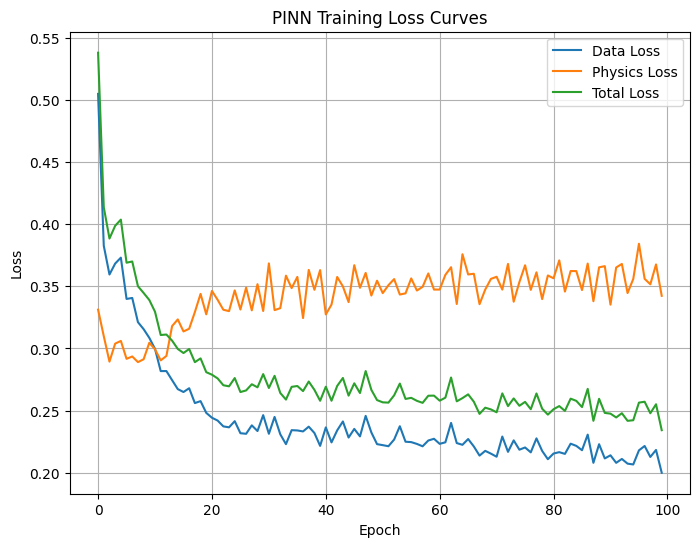

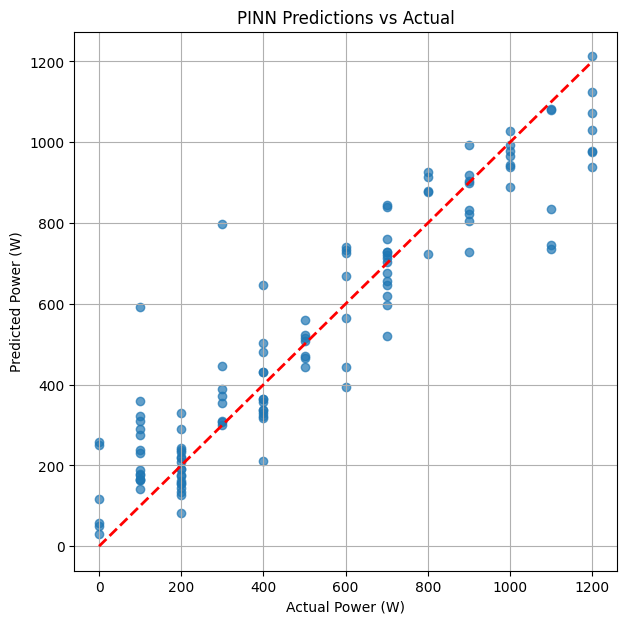

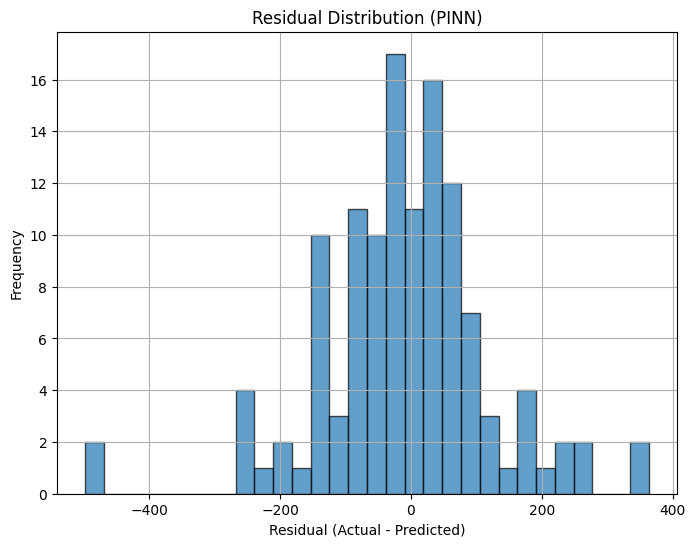

In [ ]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ===============================
# 2. Load Dataset
# ===============================
file_path = "/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv"

data = pd.read_csv(file_path, encoding="ISO-8859-1")

X = data[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y = data["P (w)"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)

# ===============================
# 3. Physics Proxy
# ===============================
K_tc = 1.0
K_te = 0.1
r = 5.0
phi_j = np.pi / 4

def compute_physics_proxy(X_batch):
    feed_rate = X_batch[:, 0]
    depth_cut = X_batch[:, 1]
    spindle_speed = X_batch[:, 2]

    h_phi = feed_rate * tf.sin(phi_j)
    F_t = K_tc * depth_cut * h_phi + K_te * depth_cut
    tau_s = r * F_t
    omega = (2 * np.pi * spindle_speed) / 60.0
    P_phys = tau_s * omega
    return tf.reshape(P_phys, (-1, 1))

# ===============================
# 4. PINN Model
# ===============================
def build_pinn(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)
    ])
    return model

# ===============================
# 5. Training with Physics Loss
# ===============================
def train_pinn(model, X_train, y_train, lambda_phys=0.1, epochs=100, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    optimizer = keras.optimizers.Adam()
    mse_loss = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        epoch_data_loss, epoch_phys_loss, epoch_total_loss = [], [], []
        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)

                data_loss = mse_loss(y_batch, y_pred)
                P_phys = compute_physics_proxy(x_batch)
                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys))

                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_loss.append(data_loss.numpy())
            epoch_phys_loss.append(phys_loss.numpy())
            epoch_total_loss.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_loss))
        history["phys_loss"].append(np.mean(epoch_phys_loss))
        history["total_loss"].append(np.mean(epoch_total_loss))

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}, Total Loss={history['total_loss'][-1]:.4f}")

    return model, history

# ===============================
# 6. Train
# ===============================
pinn = build_pinn(X_train.shape[1])
pinn, history = train_pinn(pinn, X_train_tensor, y_train_tensor,
                           lambda_phys=0.1, epochs=100, batch_size=16)

# ===============================
# 7. Evaluation
# ===============================
y_pred_scaled = pinn.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n🔹 PINN Performance:")
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

# ===============================
# 8. Plots
# ===============================

# Loss curves
plt.figure(figsize=(8,6))
plt.plot(history["data_loss"], label="Data Loss")
plt.plot(history["phys_loss"], label="Physics Loss")
plt.plot(history["total_loss"], label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Predicted vs Actual
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Power (W)")
plt.ylabel("Predicted Power (W)")
plt.title("PINN Predictions vs Actual")
plt.grid(True)
plt.show()

# Residuals
residuals = y_test.flatten() - y_pred.flatten()
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (PINN)")
plt.grid(True)
plt.show()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔹 ANN Performance:
MSE: 8835.6787109375
MAE: 71.18433380126953
R2: 0.9299139380455017


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔹 PINN Performance:
MSE: 583012224.0
MAE: 20137.064453125
R2: -4623.55078125


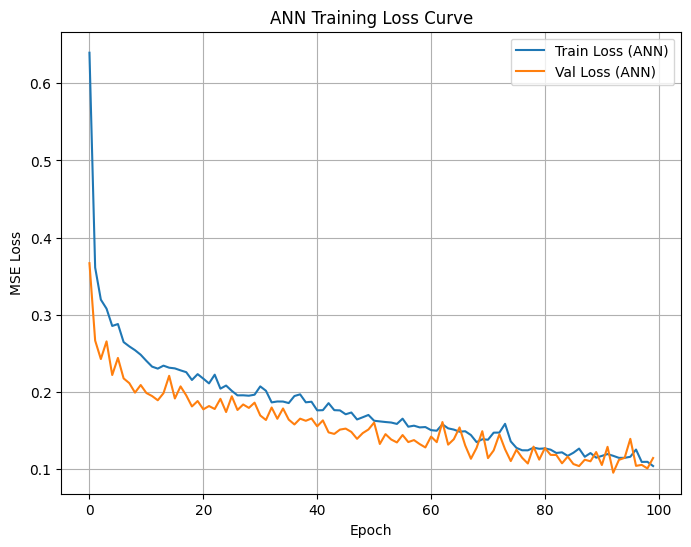

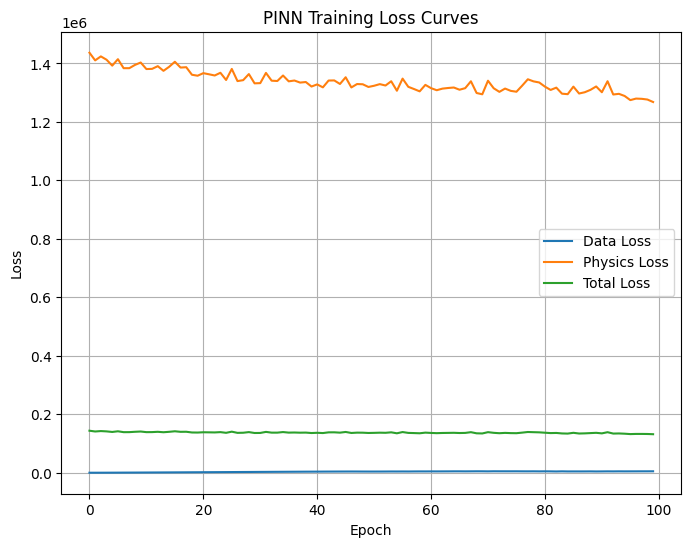

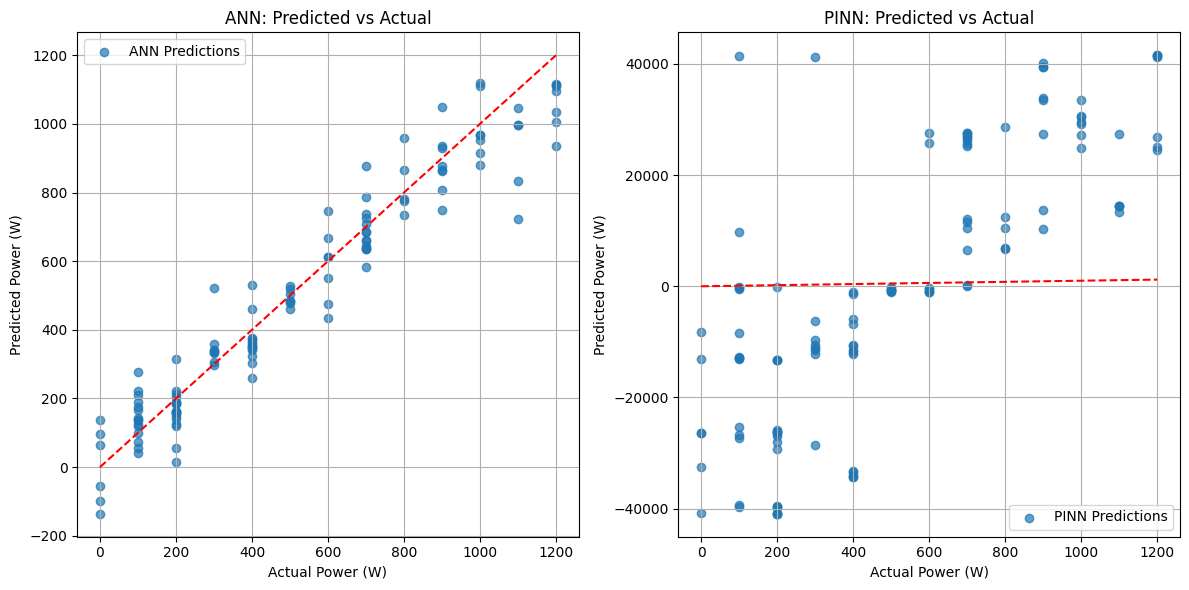

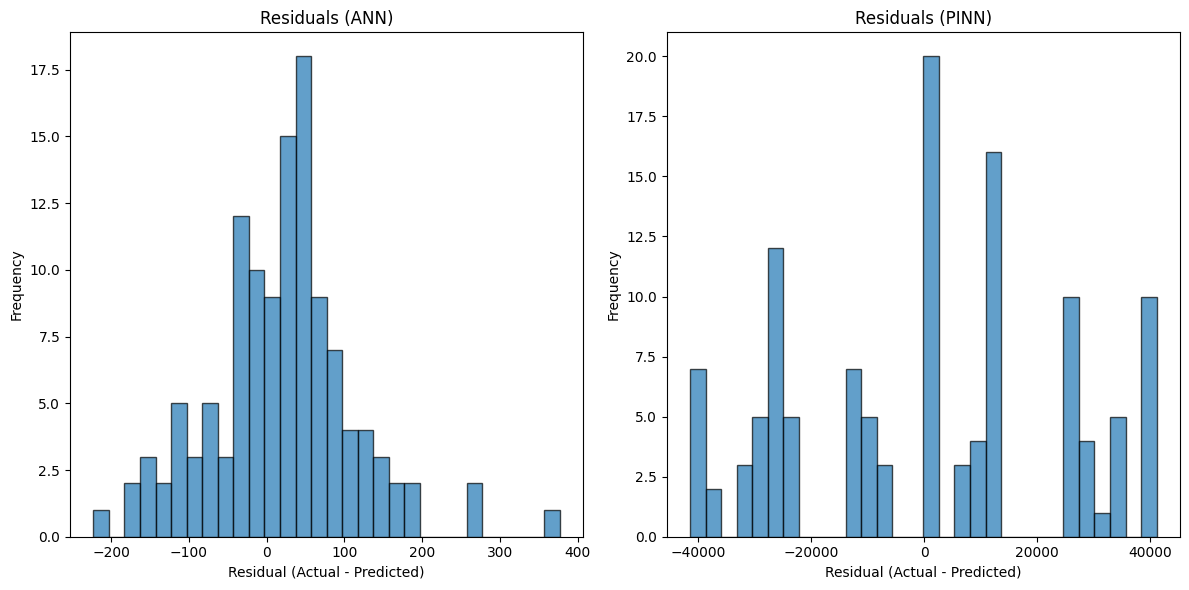

In [ ]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

# ===============================
# 2. Load Dataset
# ===============================
file_path = "/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv"

data = pd.read_csv(file_path, encoding="ISO-8859-1")

X = data[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y = data["P (w)"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)

# ===============================
# 3. Physics Proxy (from theory)
# ===============================
K_tc = 2517.58
K_te = 18.9
r = 5.0
phi_j = np.pi / 4

def compute_physics_proxy(X_batch):
    feed_rate = X_batch[:, 0]
    depth_cut = X_batch[:, 1]
    spindle_speed = X_batch[:, 2]

    h_phi = feed_rate * tf.sin(phi_j)
    F_t = K_tc * depth_cut * h_phi + K_te * depth_cut
    tau_s = r * F_t
    omega = (2 * np.pi * spindle_speed) / 60.0
    P_phys = tau_s * omega
    return tf.reshape(P_phys, (-1, 1))

# ===============================
# 4. Build Models
# ===============================
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_pinn(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)
    ])
    return model

# ===============================
# 5. Train ANN (Pure Data-Driven)
# ===============================
ann = build_ann(X_train.shape[1])

history_ann = ann.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=0
)

# Save ANN
ann.save("/content/ann_model.h5")

# Evaluate ANN
y_pred_ann_scaled = ann.predict(X_test_scaled)
y_pred_ann = scaler_y.inverse_transform(y_pred_ann_scaled)

mse_ann = mean_squared_error(y_test, y_pred_ann)
mae_ann = mean_absolute_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print("\n🔹 ANN Performance:")
print("MSE:", mse_ann)
print("MAE:", mae_ann)
print("R2:", r2_ann)

# ===============================
# 6. Train PINN (Hybrid)
# ===============================
def train_pinn(model, X_train, y_train, lambda_phys=0.1, epochs=100, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    optimizer = keras.optimizers.Adam()
    mse_loss = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        epoch_data_loss, epoch_phys_loss, epoch_total_loss = [], [], []
        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)

                data_loss = mse_loss(y_batch, y_pred)
                P_phys = compute_physics_proxy(x_batch)
                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys))

                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_loss.append(data_loss.numpy())
            epoch_phys_loss.append(phys_loss.numpy())
            epoch_total_loss.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_loss))
        history["phys_loss"].append(np.mean(epoch_phys_loss))
        history["total_loss"].append(np.mean(epoch_total_loss))

    return model, history

pinn = build_pinn(X_train.shape[1])
pinn, history_pinn = train_pinn(pinn, X_train_tensor, y_train_tensor,
                                lambda_phys=0.1, epochs=100, batch_size=16)

# Save PINN
pinn.save("/content/pinn_model.h5")

# Evaluate PINN
y_pred_pinn_scaled = pinn.predict(X_test_scaled)
y_pred_pinn = scaler_y.inverse_transform(y_pred_pinn_scaled)

mse_pinn = mean_squared_error(y_test, y_pred_pinn)
mae_pinn = mean_absolute_error(y_test, y_pred_pinn)
r2_pinn = r2_score(y_test, y_pred_pinn)

print("\n🔹 PINN Performance:")
print("MSE:", mse_pinn)
print("MAE:", mae_pinn)
print("R2:", r2_pinn)

# ===============================
# 7. Plots
# ===============================

# ANN Loss Curve
plt.figure(figsize=(8,6))
plt.plot(history_ann.history["loss"], label="Train Loss (ANN)")
plt.plot(history_ann.history["val_loss"], label="Val Loss (ANN)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("ANN Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# PINN Loss Curves
plt.figure(figsize=(8,6))
plt.plot(history_pinn["data_loss"], label="Data Loss")
plt.plot(history_pinn["phys_loss"], label="Physics Loss")
plt.plot(history_pinn["total_loss"], label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Predicted vs Actual (Comparison)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ann, alpha=0.7, label="ANN Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Power (W)")
plt.ylabel("Predicted Power (W)")
plt.title("ANN: Predicted vs Actual")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_pinn, alpha=0.7, label="PINN Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Power (W)")
plt.ylabel("Predicted Power (W)")
plt.title("PINN: Predicted vs Actual")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Residuals Comparison
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(y_test.flatten() - y_pred_ann.flatten(), bins=30, edgecolor='k', alpha=0.7)
plt.title("Residuals (ANN)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(y_test.flatten() - y_pred_pinn.flatten(), bins=30, edgecolor='k', alpha=0.7)
plt.title("Residuals (PINN)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


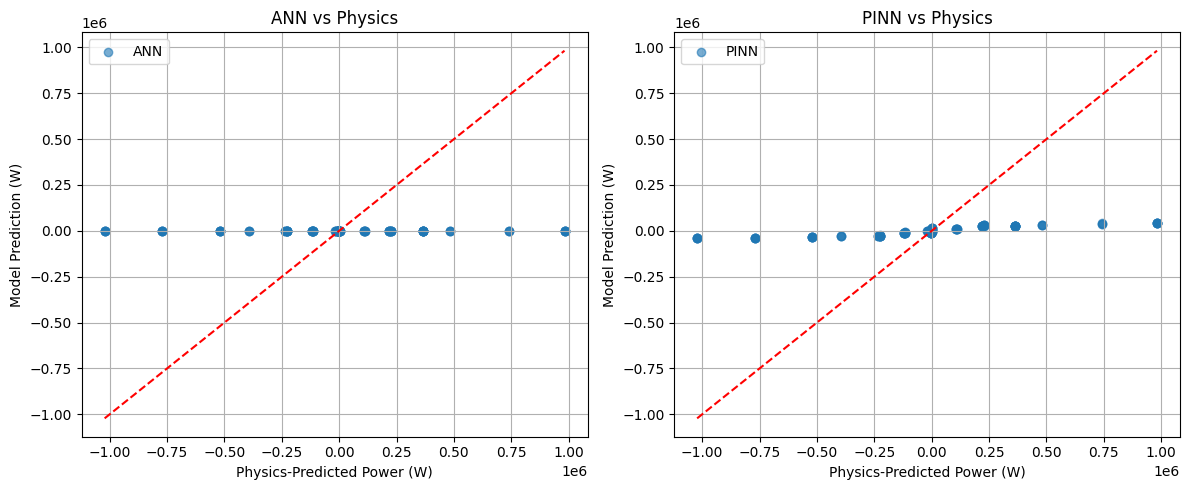

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


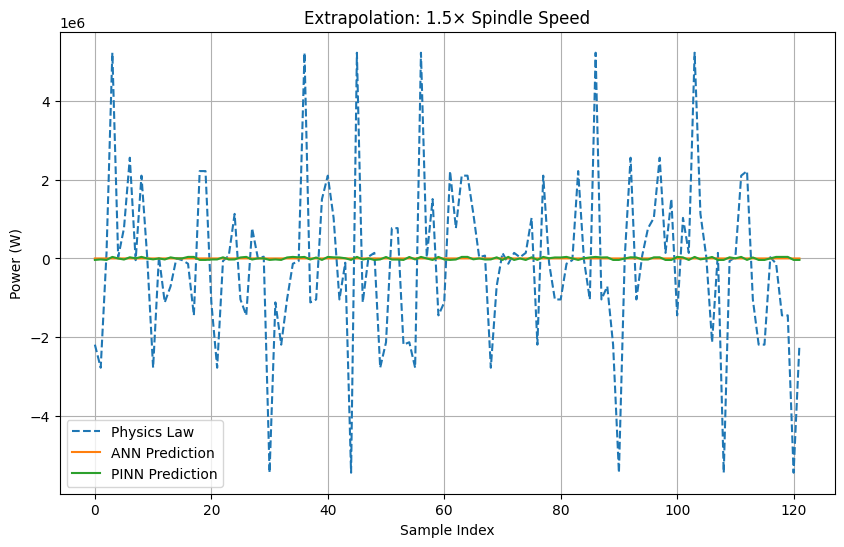

In [ ]:
# ===============================
# 8. Physics Consistency Check
# ===============================
# Compute physics power for test set
P_phys_test = compute_physics_proxy(tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)).numpy()
P_phys_test = scaler_y.inverse_transform(P_phys_test)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(P_phys_test, y_pred_ann, alpha=0.6, label="ANN")
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel("Physics-Predicted Power (W)")
plt.ylabel("Model Prediction (W)")
plt.title("ANN vs Physics")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(P_phys_test, y_pred_pinn, alpha=0.6, label="PINN")
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel("Physics-Predicted Power (W)")
plt.ylabel("Model Prediction (W)")
plt.title("PINN vs Physics")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ===============================
# 9. Extrapolation Test
# ===============================
# Artificially test beyond training range
X_extrap = X_test.copy()
X_extrap[:,2] = X_extrap[:,2] * 1.5  # 50% higher spindle speed
X_extrap_scaled = scaler_X.transform(X_extrap)

y_pred_ann_extra = scaler_y.inverse_transform(ann.predict(X_extrap_scaled))
y_pred_pinn_extra = scaler_y.inverse_transform(pinn.predict(X_extrap_scaled))
P_phys_extra = compute_physics_proxy(tf.convert_to_tensor(X_extrap_scaled, dtype=tf.float32)).numpy()
P_phys_extra = scaler_y.inverse_transform(P_phys_extra)

plt.figure(figsize=(10,6))
plt.plot(P_phys_extra, label="Physics Law", linestyle="--")
plt.plot(y_pred_ann_extra, label="ANN Prediction")
plt.plot(y_pred_pinn_extra, label="PINN Prediction")
plt.title("Extrapolation: 1.5× Spindle Speed")
plt.xlabel("Sample Index")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)
plt.show()


Expected Outcome

ANN will show high R² on training/test but deviate badly from physics when extrapolated.

PINN will have lower R² but stay close to physics in both interpolation and extrapolation.

Code to improve PINN

In [ ]:
# ===============================
# Improved PINN Training
# ===============================
def train_pinn(model, X_train, y_train, lambda_phys=0.01, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    mse_loss = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        epoch_data_loss, epoch_phys_loss, epoch_total_loss = [], [], []

        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)

                # Data-driven loss
                data_loss = mse_loss(y_batch, y_pred)

                # Physics-based loss (torque * angular velocity model)
                feed_rate = x_batch[:, 0]
                depth_cut = x_batch[:, 1]
                spindle_speed = x_batch[:, 2]

                # Cutting physics (simplified but closer to reality)
                h_phi = feed_rate * tf.sin(np.pi/4)   # average chip thickness
                F_t = (1.5 * depth_cut * h_phi) + (0.05 * depth_cut)   # tangential cutting force
                tau_s = 5.0 * F_t
                omega = (2 * np.pi * spindle_speed) / 60.0
                P_phys = tf.reshape(tau_s * omega, (-1,1))

                # Match scales with y
                P_phys_scaled = scaler_y.transform(P_phys.numpy())
                P_phys_scaled = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_scaled))

                # Adaptive λ (reduce if physics too strong)
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_loss.append(data_loss.numpy())
            epoch_phys_loss.append(phys_loss.numpy())
            epoch_total_loss.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_loss))
        history["phys_loss"].append(np.mean(epoch_phys_loss))
        history["total_loss"].append(np.mean(epoch_total_loss))

        # Adaptive lambda update every 50 epochs
        if (epoch+1) % 50 == 0:
            lambda_phys *= 0.5

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Data Loss={history['data_loss'][-1]:.4f}, "
                  f"Phys Loss={history['phys_loss'][-1]:.4f}, Total={history['total_loss'][-1]:.4f}")

    return model, history

# ===============================
# Train Improved PINN
# ===============================
pinn = build_pinn(X_train.shape[1])
pinn, history_pinn = train_pinn(pinn, X_train_tensor, y_train_tensor,
                                lambda_phys=0.01, epochs=300, batch_size=32)

# Evaluate
y_pred_scaled = pinn.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse_pinn = mean_squared_error(y_test, y_pred)
mae_pinn = mean_absolute_error(y_test, y_pred)
r2_pinn = r2_score(y_test, y_pred)

print("\n🔹 Improved PINN Performance:")
print("MSE:", mse_pinn)
print("MAE:", mae_pinn)
print("R2:", r2_pinn)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20, Data Loss=0.2643, Phys Loss=3.0583, Total=0.2949
Epoch 40, Data Loss=0.2392, Phys Loss=2.9477, Total=0.2687
Epoch 60, Data Loss=0.2133, Phys Loss=3.1164, Total=0.2288
Epoch 80, Data Loss=0.2292, Phys Loss=3.1802, Total=0.2451
Epoch 100, Data Loss=0.2065, Phys Loss=3.0400, Total=0.2217
Epoch 120, Data Loss=0.2000, Phys Loss=3.1727, Total=0.2080
Epoch 140, Data Loss=0.1978, Phys Loss=3.0866, Total=0.2055
Epoch 160, Data Loss=0.1652, Phys Loss=2.9880, Total=0.1689
Epoch 180, Data Loss=0.1582, Phys Loss=3.1950, Total=0.1622
Epoch 200, Data Loss=0.1349, Phys Loss=3.2109, Total=0.1389
Epoch 220, Data Loss=0.1274, Phys Loss=3.1977, Total=0.1294
Epoch 240, Data Loss=0.1234, Phys Loss=3.0696, Total=0.1253
Epoch 260, Data Loss=0.1062, Phys Loss=3.2595, Total=0.1072
Epoch 280, Data Loss=0.1005, Phys Loss=3.1420, Total=0.1015
Epoch 300, Data Loss=0.0933, Phys Loss=3.1956, Total=0.0943
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

🔹 Improved PINN Performance:
MSE: 7750.5888671875
MAE: 63.7300910

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.0721 - val_loss: 0.6428
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5657 - val_loss: 0.3651
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4188 - val_loss: 0.2585
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3289 - val_loss: 0.2358
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3839 - val_loss: 0.2247
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2908 - val_loss: 0.2186
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2930 - val_loss: 0.2084
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2569 - val_loss: 0.2102
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2910 - val_loss: 0.2064
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2610 - val_loss: 0.1941
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2182 - val_loss: 0.2096
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

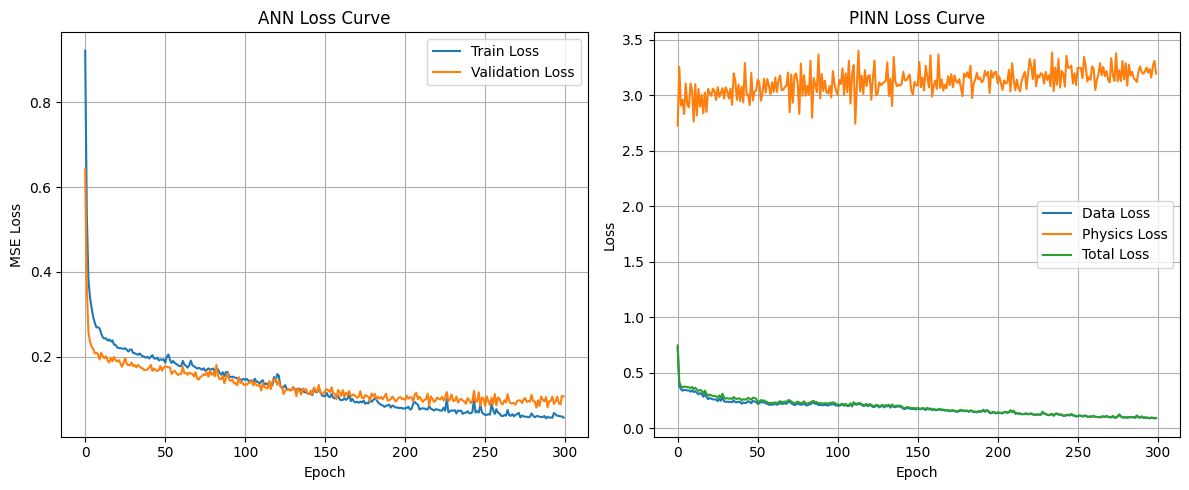

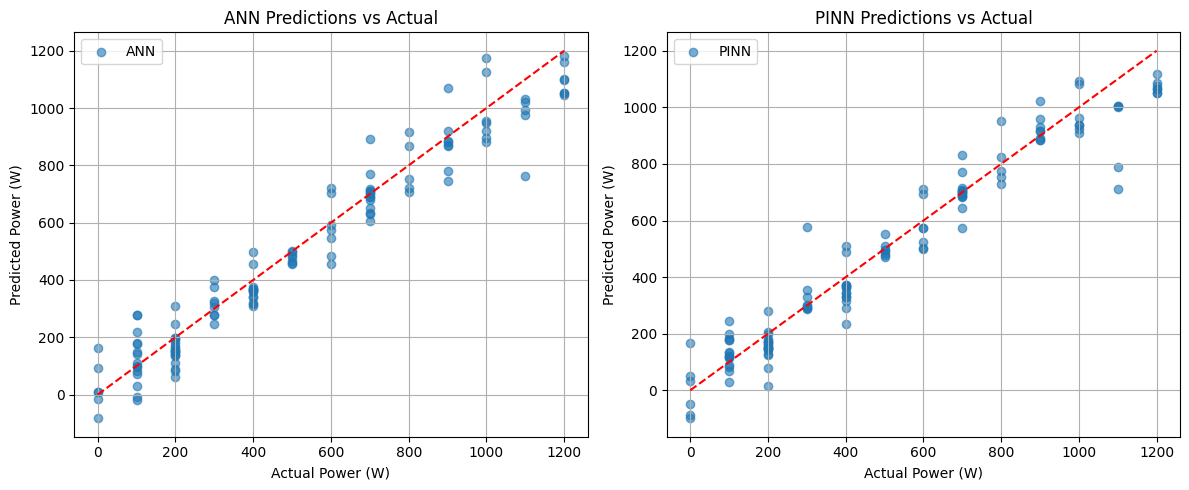

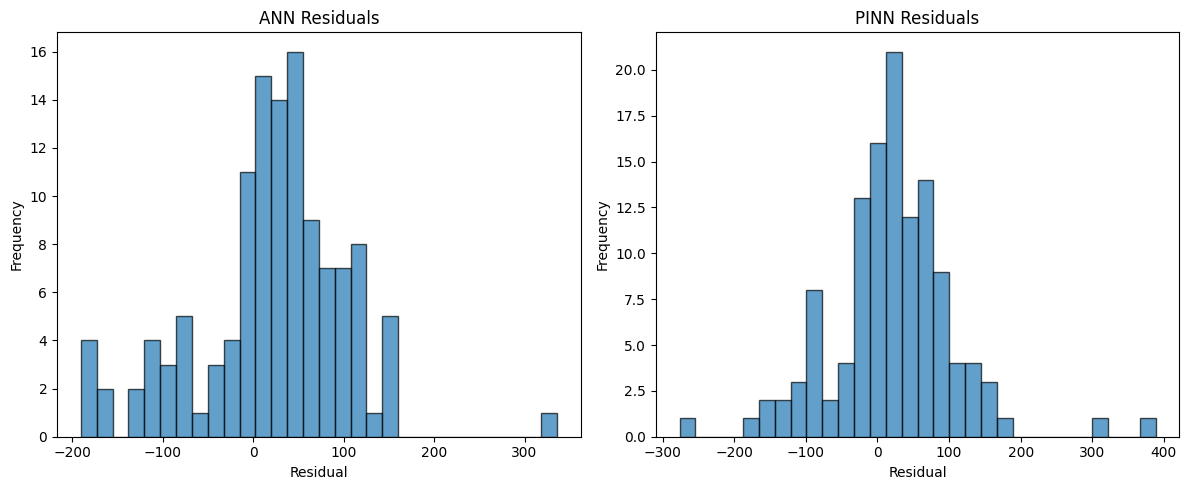

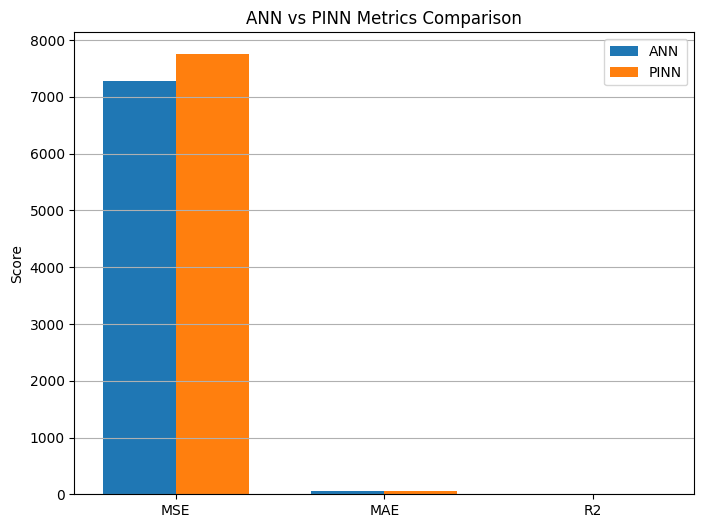

In [ ]:
# ===============================
# 1. Simple ANN (Baseline)
# ===============================
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse")
    return model

ann = build_ann(X_train.shape[1])

history_ann = ann.fit(X_train_scaled, y_train_scaled,
                      validation_split=0.2,
                      epochs=300,
                      batch_size=32,
                      verbose=1)

# Evaluate ANN
y_pred_ann_scaled = ann.predict(X_test_scaled)
y_pred_ann = scaler_y.inverse_transform(y_pred_ann_scaled)

mse_ann = mean_squared_error(y_test, y_pred_ann)
mae_ann = mean_absolute_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print("\n🔹 ANN Performance:")
print("MSE:", mse_ann)
print("MAE:", mae_ann)
print("R2:", r2_ann)

# ===============================
# 2. Improved PINN (already trained in your code)
# ===============================
# Already have pinn, history_pinn, y_pred, mse_pinn, mae_pinn, r2_pinn

# ===============================
# 3. Comparative Plots
# ===============================

# ---- Loss Curves ----
plt.figure(figsize=(12,5))

# ANN loss
plt.subplot(1,2,1)
plt.plot(history_ann.history["loss"], label="Train Loss")
plt.plot(history_ann.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("ANN Loss Curve")
plt.legend()
plt.grid(True)

# PINN loss
plt.subplot(1,2,2)
plt.plot(history_pinn["data_loss"], label="Data Loss")
plt.plot(history_pinn["phys_loss"], label="Physics Loss")
plt.plot(history_pinn["total_loss"], label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Loss Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- Predicted vs Actual ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ann, alpha=0.6, label="ANN")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Power (W)")
plt.ylabel("Predicted Power (W)")
plt.title("ANN Predictions vs Actual")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred, alpha=0.6, label="PINN")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Power (W)")
plt.ylabel("Predicted Power (W)")
plt.title("PINN Predictions vs Actual")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- Residual Distributions ----
plt.figure(figsize=(12,5))

residuals_ann = y_test.flatten() - y_pred_ann.flatten()
residuals_pinn = y_test.flatten() - y_pred.flatten()

plt.subplot(1,2,1)
plt.hist(residuals_ann, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("ANN Residuals")

plt.subplot(1,2,2)
plt.hist(residuals_pinn, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("PINN Residuals")

plt.tight_layout()
plt.show()

# ---- Comparative Bar Chart ----
metrics = ["MSE", "MAE", "R2"]
ann_scores = [mse_ann, mae_ann, r2_ann]
pinn_scores = [mse_pinn, mae_pinn, r2_pinn]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, ann_scores, width, label="ANN")
plt.bar(x + width/2, pinn_scores, width, label="PINN")
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("ANN vs PINN Metrics Comparison")
plt.legend()
plt.grid(True, axis='y')
plt.show()


In [ ]:
# ===============================
# Improved PINN Training (Better Physics Proxy)
# ===============================
def train_pinn(model, X_train, y_train, lambda_phys=0.01, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    mse_loss = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        epoch_data_loss, epoch_phys_loss, epoch_total_loss = [], [], []

        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)

                # Data loss
                data_loss = mse_loss(y_batch, y_pred)

                # ----------------------------
                # Physics-based proxy
                # ----------------------------
                feed_rate = x_batch[:, 0]
                depth_cut = x_batch[:, 1]
                spindle_speed = x_batch[:, 2]

                # Simplified power law
                # P_phys = C * (depth * feed_rate * spindle_speed)
                C = 0.001  # scaling constant (tune to your dataset!)
                P_phys = C * depth_cut * feed_rate * spindle_speed
                P_phys = tf.reshape(P_phys, (-1,1))

                # Scale physics proxy to y-scale
                P_phys_scaled = scaler_y.transform(P_phys.numpy())
                P_phys_scaled = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_scaled))

                # Weighted total loss
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_loss.append(data_loss.numpy())
            epoch_phys_loss.append(phys_loss.numpy())
            epoch_total_loss.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_loss))
        history["phys_loss"].append(np.mean(epoch_phys_loss))
        history["total_loss"].append(np.mean(epoch_total_loss))

        # Lower λ adaptively
        if (epoch+1) % 50 == 0:
            lambda_phys *= 0.7

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Data Loss={history['data_loss'][-1]:.4f}, "
                  f"Phys Loss={history['phys_loss'][-1]:.4f}, Total={history['total_loss'][-1]:.4f}")

    return model, history


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

🔹 ANN Performance:
MSE: 7164.12548828125
MAE: 64.5733413696289
R2: 0.9431729316711426


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20, Data Loss=0.3133, Phys Loss=2.9339, Total=0.3427
Epoch 40, Data Loss=0.2349, Phys Loss=3.1229, Total=0.2661
Epoch 60, Data Loss=0.2217, Phys Loss=3.0877, Total=0.2433
Epoch 80, Data Loss=0.2058, Phys Loss=2.9108, Total=0.2262
Epoch 100, Data Loss=0.1955, Phys Loss=3.0109, Total=0.2166
Epoch 120, Data Loss=0.1948, Phys Loss=3.0758, Total=0.2099
Epoch 140, Data Loss=0.2010, Phys Loss=3.0881, Total=0.2162
Epoch 160, Data Loss=0.1741, Phys Loss=3.0093, Total=0.1845
Epoch 180, Data Loss=0.1590, Phys Loss=3.2143, Total=0.1700
Epoch 200, Data Loss=0.1533, Phys Loss=3.2376, Total=0.1644
Epoch 220, Data Loss=0.1247, Phys Loss=3.1183, Total=0.1322
Epoch 240, Data Loss=0.1278, Phys Loss=3.0095, Total=0.1351
Epoch 260, Data Loss=0.1177, Phys Loss=3.2049, Total=0.1231
Epoch 280, Data Loss=0.1059, Phys Loss=3.2273, Total=0.1113
Epoch 300, Data Loss=0.0964, Phys Loss=3.2109, Total=0.1018
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

🔹 PINN Performance:
MSE: 8254.6396484375
MAE: 67.03067016601562
R

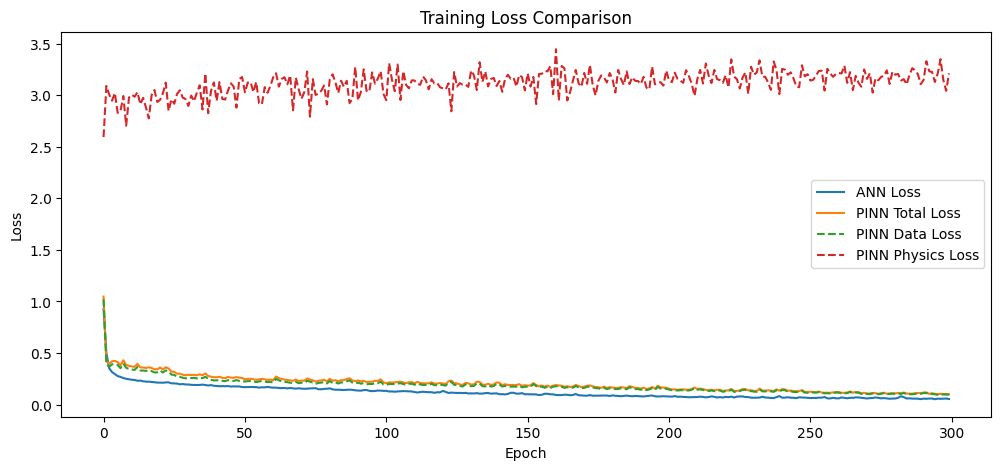

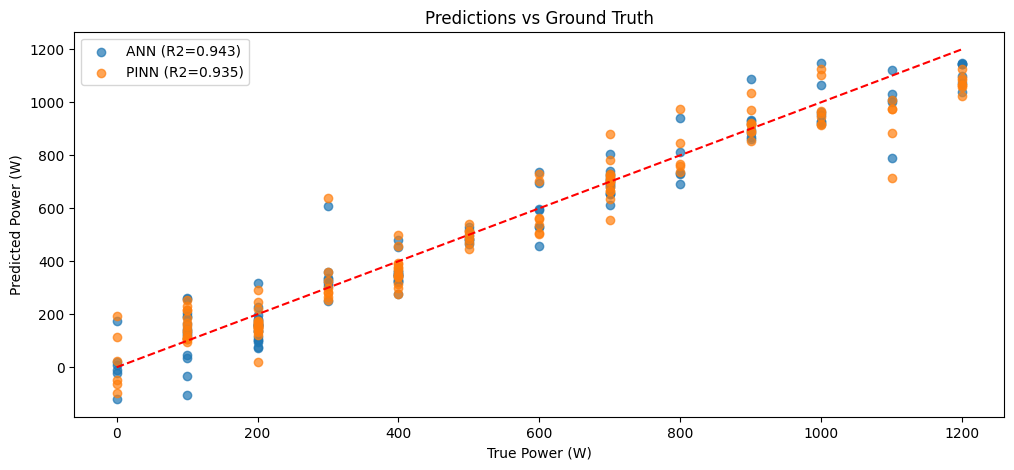

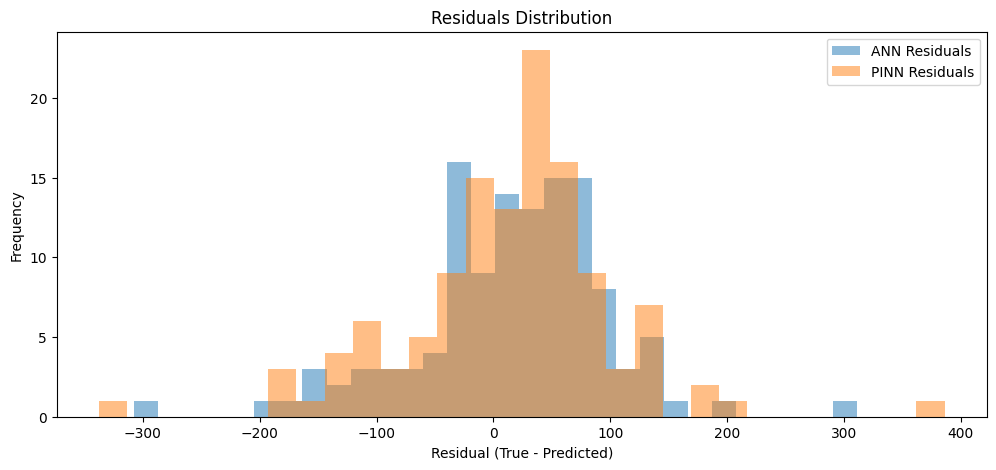

In [ ]:
# ============================================
# 1. Import Libraries
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============================================
# 2. Load Data
# ============================================
data = pd.read_csv("/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv",
                   encoding="ISO-8859-1")

X = data[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y = data["P (w)"].values.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)

# ============================================
# 3. Build Simple ANN
# ============================================
def build_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

# Train ANN
ann = build_ann(X_train.shape[1])
history_ann = ann.fit(X_train_scaled, y_train_scaled,
                      epochs=300, batch_size=32, verbose=0,
                      validation_split=0.1)

# Predictions ANN
y_pred_ann_scaled = ann.predict(X_test_scaled)
y_pred_ann = scaler_y.inverse_transform(y_pred_ann_scaled)

mse_ann = mean_squared_error(y_test, y_pred_ann)
mae_ann = mean_absolute_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print("\n🔹 ANN Performance:")
print("MSE:", mse_ann)
print("MAE:", mae_ann)
print("R2:", r2_ann)

# ============================================
# 4. Build PINN
# ============================================
def build_pinn(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='tanh', input_shape=(input_dim,)),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(1)
    ])
    return model

# Custom training loop with physics-informed loss
def train_pinn(model, X_train, y_train, lambda_phys=0.01, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    mse_loss = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        epoch_data_loss, epoch_phys_loss, epoch_total_loss = [], [], []

        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)

                # Data loss
                data_loss = mse_loss(y_batch, y_pred)

                # ----------------------------
                # Physics-based proxy
                # ----------------------------
                feed_rate = x_batch[:, 0]
                depth_cut = x_batch[:, 1]
                spindle_speed = x_batch[:, 2]

                # Simple cutting power law (scalable)
                C = 0.001
                P_phys = C * depth_cut * feed_rate * spindle_speed
                P_phys = tf.reshape(P_phys, (-1,1))

                # Scale to same range as target
                P_phys_scaled = scaler_y.transform(P_phys.numpy())
                P_phys_scaled = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                # Physics loss
                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_scaled))

                # Total loss
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_loss.append(data_loss.numpy())
            epoch_phys_loss.append(phys_loss.numpy())
            epoch_total_loss.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_loss))
        history["phys_loss"].append(np.mean(epoch_phys_loss))
        history["total_loss"].append(np.mean(epoch_total_loss))

        # Adaptive λ
        if (epoch+1) % 50 == 0:
            lambda_phys *= 0.7

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Data Loss={history['data_loss'][-1]:.4f}, "
                  f"Phys Loss={history['phys_loss'][-1]:.4f}, Total={history['total_loss'][-1]:.4f}")

    return model, history

# Train PINN
pinn = build_pinn(X_train.shape[1])
pinn, history_pinn = train_pinn(pinn, X_train_tensor, y_train_tensor,
                                lambda_phys=0.01, epochs=300, batch_size=32)

# Predictions PINN
y_pred_pinn_scaled = pinn.predict(X_test_scaled)
y_pred_pinn = scaler_y.inverse_transform(y_pred_pinn_scaled)

mse_pinn = mean_squared_error(y_test, y_pred_pinn)
mae_pinn = mean_absolute_error(y_test, y_pred_pinn)
r2_pinn = r2_score(y_test, y_pred_pinn)

print("\n🔹 PINN Performance:")
print("MSE:", mse_pinn)
print("MAE:", mae_pinn)
print("R2:", r2_pinn)

# ============================================
# 5. Comparative Plots
# ============================================
plt.figure(figsize=(12,5))
plt.plot(history_ann.history['loss'], label="ANN Loss")
plt.plot(history_pinn['total_loss'], label="PINN Total Loss")
plt.plot(history_pinn['data_loss'], '--', label="PINN Data Loss")
plt.plot(history_pinn['phys_loss'], '--', label="PINN Physics Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Predictions vs Ground Truth
plt.figure(figsize=(12,5))
plt.scatter(y_test, y_pred_ann, label=f"ANN (R2={r2_ann:.3f})", alpha=0.7)
plt.scatter(y_test, y_pred_pinn, label=f"PINN (R2={r2_pinn:.3f})", alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Power (W)")
plt.ylabel("Predicted Power (W)")
plt.title("Predictions vs Ground Truth")
plt.legend()
plt.show()

# Residuals
plt.figure(figsize=(12,5))
plt.hist(y_test - y_pred_ann, bins=30, alpha=0.5, label="ANN Residuals")
plt.hist(y_test - y_pred_pinn, bins=30, alpha=0.5, label="PINN Residuals")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.legend()
plt.show()

# ============================================
# 6. Save Models
# ============================================
ann.save("simple_ann_model.keras")
pinn.save("pinn_model.keras")


Using file: /content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv
Data rows: 610
['Feed Rate /Flute (mm/flute)', 'Feed Rate', 'Depth Of Cut (mm)', 'Spindle Speed', 'Time (Sec)', 'P (w)']
Physics proxy sample (W): [0.57645   4.1135178 1.9297283 2.4681106 1.1529   ]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

ANN test metrics -> MSE: 6585.019, MAE: 61.046, R2: 0.9478
Epoch 1/300 -> data_loss=0.754616, phys_loss=2.544992, total=0.805516, lam=0.02000
Epoch 25/300 -> data_loss=0.304029, phys_loss=3.005107, total=0.364131, lam=0.02000
Epoch 50/300 -> data_loss=0.239179, phys_loss=3.064004, total=0.300459, lam=0.01400
Epoch 75/300 -> data_loss=0.204750, phys_loss=2.978549, total=0.246450, lam=0.01400
Epoch 100/300 -> data_loss=0.208150, phys_loss=3.190928, total=0.252823, lam=0.00980
Epoch 125/300 -> data_loss=0.172034, phys_loss=3.142636, total=0.202832, lam=0.00980
Epoch 150/300 -> data_loss=0.152709, phys_loss=3.068130, total=0.182777, lam=0.00686
Epoch 175/300 -> data_loss=0.153689, p

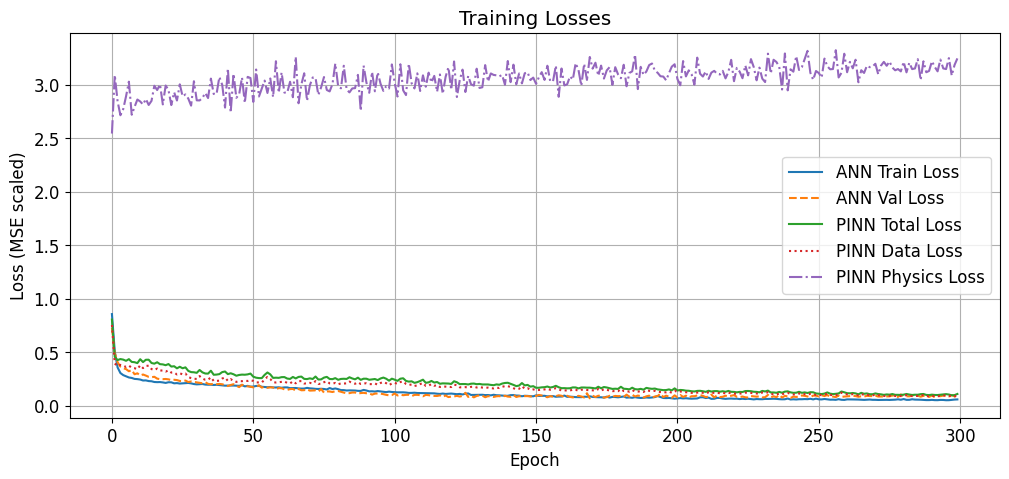

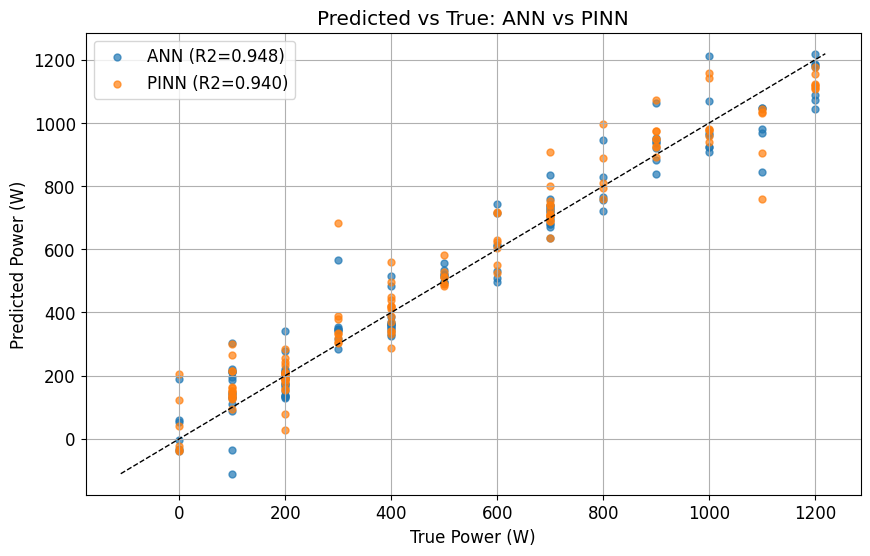

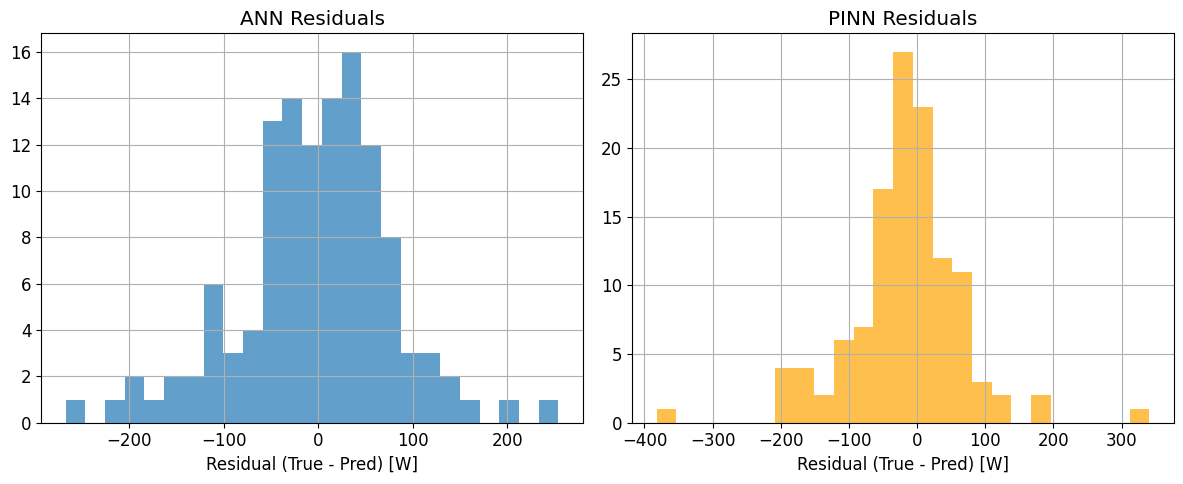

/tmp/ipython-input-1547272972.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([abs_ann, abs_pinn], labels=['ANN', 'PINN'])


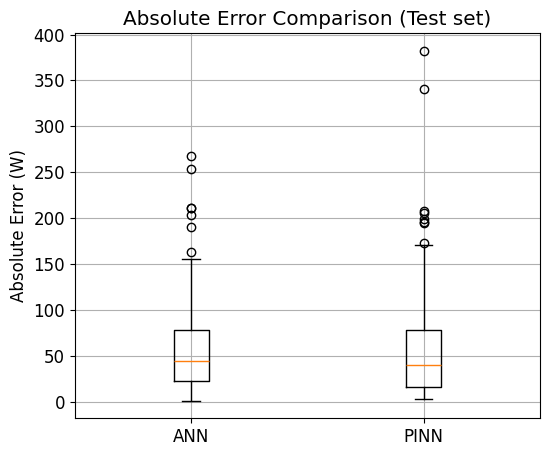

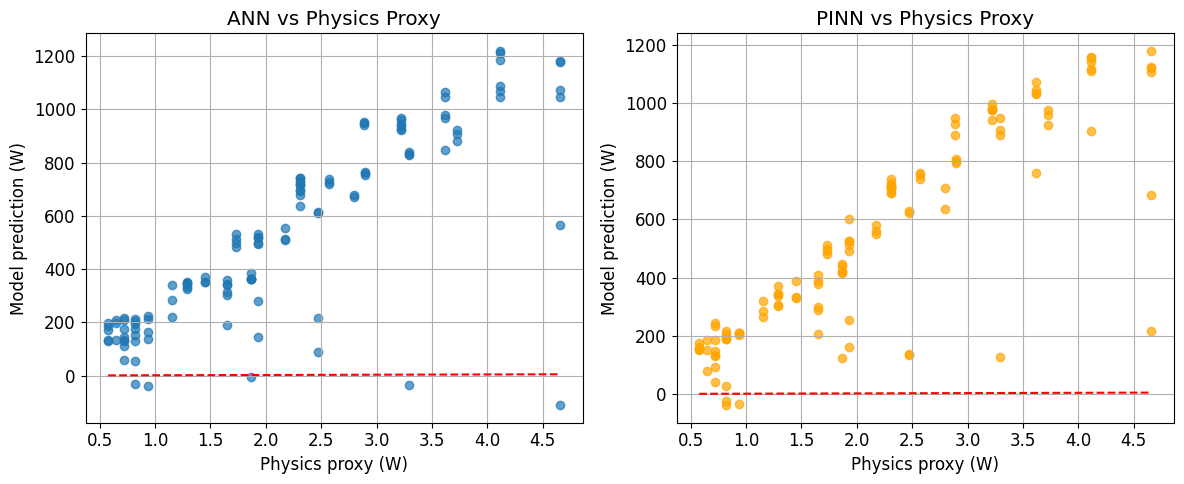

In [ ]:
# =========================
# Full script: ANN vs PINN
# Uses K_tc=2517.58, K_te=18.9, r=5.0 (mm), phi_j=35 degrees
# =========================

# 0) Install (uncomment in Colab if needed)
# !pip install --upgrade pip
# !pip install chardet xgboost --quiet

# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# 2) Load data - change path if required
# If the file is in Colab drive use that path instead
file_path = "/mnt/data/Gear_training.csv"   # or "/content/drive/MyDrive/..." if using Drive
if not os.path.exists(file_path):
    # fallback: try common drive path (uncomment if needed)
    file_path = "/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv"

print("Using file:", file_path)
df = pd.read_csv(file_path, encoding="ISO-8859-1")
print("Data rows:", len(df))
print(df.columns.tolist())

# 3) Prepare features / target
# The table you showed uses Feed per flute = 0.1 mm/flute; but dataset columns may be 'Feed Rate' etc.
# We use these columns (adjust if your CSV column names differ)
feature_cols = ["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]
for c in feature_cols + ["P (w)"]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in CSV. Found columns: {df.columns.tolist()}")

X = df[feature_cols].astype(float).values      # [Fs, a(mm), Ns, T]
y = df["P (w)"].astype(float).values.reshape(-1,1)

# 4) Train-test split + scalers
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

X_train = scaler_X.transform(X_train_raw).astype(np.float32)
X_test = scaler_X.transform(X_test_raw).astype(np.float32)
y_train = scaler_y.transform(y_train_raw).astype(np.float32)
y_test = scaler_y.transform(y_test_raw).astype(np.float32)

# Convert to TF tensors for PINN training
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

# 5) Physics constants (from you)
K_tc = 2517.58   # as provided
K_te = 18.9
r_mm = 5.0       # mm
r_m = r_mm / 1000.0  # convert to meters
phi_deg = 35.0
phi_j = np.deg2rad(phi_deg)

# Physics function using raw (unscaled) inputs (X_raw rows)
def physics_power_from_raw(X_raw_rows):
    """
    X_raw_rows: numpy array shape (n,4)
      columns: [Feed Rate (mm/flute or mm/min?), Depth Of Cut (mm), Spindle Speed (rpm), Time (sec)]
    Returns: P_phys (n,1) in Watts (using consistent units: m, N, rad/s)
    """
    # Interpret column order:
    # Feed per flute (Fs) in mm (user uses Feed Rate column as Fs)
    Fs_mm = X_raw_rows[:, 0].astype(np.float64)
    a_mm = X_raw_rows[:, 1].astype(np.float64)        # depth of cut (mm)
    Ns = X_raw_rows[:, 2].astype(np.float64)          # spindle speed (rpm)

    # convert mm to m where needed
    a_m = a_mm / 1000.0
    Fs_m = Fs_mm / 1000.0

    # chip thickness
    h_phi = Fs_m * np.sin(phi_j)   # m

    # Ft = Ktc * a * h + Kte * a
    # Here K_tc is applied assuming units consistent with a_m and h_phi -> choose K_tc in N/m^2
    Ft = K_tc * a_m * h_phi + K_te * a_m   # N

    # torque tau_s = r * Ft (use r_m in meters)
    tau_s = r_m * Ft   # N·m

    # angular speed
    omega = 2.0 * np.pi * Ns / 60.0  # rad/s

    # spindle power
    P_phy = (tau_s * omega).reshape(-1,1)   # Watts

    return P_phy.astype(np.float32)

# Quick physics sanity check (first 5 train rows)
P_phy_sample = physics_power_from_raw(X_train_raw[:5])
print("Physics proxy sample (W):", P_phy_sample.flatten()[:5])

# 6) Build ANN (data-only)
def build_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

# 7) Build PINN model (same base architecture, tanh activations)
def build_pinn(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(1)
    ])
    return model

# 8) Train ANN for same epochs (300)
EPOCHS = 300
BATCH = 32

ann = build_ann(X_train.shape[1])
history_ann = ann.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=0)

# ANN predictions (unscaled)
yhat_ann_scaled = ann.predict(X_test)
yhat_ann = scaler_y.inverse_transform(yhat_ann_scaled)

mse_ann = mean_squared_error(y_test_raw, yhat_ann)
mae_ann = mean_absolute_error(y_test_raw, yhat_ann)
r2_ann = r2_score(y_test_raw, yhat_ann)
print("\nANN test metrics -> MSE: %.3f, MAE: %.3f, R2: %.4f" % (mse_ann, mae_ann, r2_ann))

# 9) Improved PINN training: use physics proxy but scale it to target's scaler_y scale
def train_pinn_with_physics(model, X_train_scaled, X_train_raw, y_train_scaled,
                            lambda_phys=0.02, epochs=EPOCHS, batch_size=BATCH,
                            adaptive_lambda=True, verbose=True):
    """
    model: keras model (uncompiled)
    X_train_scaled: scaled inputs (np.array)
    X_train_raw: raw inputs in original units (np.array) (used for physics)
    y_train_scaled: scaled targets (np.array)
    """
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}
    lam = lambda_phys

    for epoch in range(epochs):
        epoch_data_losses = []
        epoch_phys_losses = []
        epoch_total_losses = []

        for x_scaled_batch, x_raw_batch, y_batch in dataset:
            # x_scaled_batch: scaled inputs (for model). x_raw_batch: raw physical units (for physics)
            with tf.GradientTape() as tape:
                y_pred_scaled = model(x_scaled_batch, training=True)   # predicted in scaled target space

                # data loss (on scaled targets)
                data_loss = mse(y_batch, y_pred_scaled)

                # physics prediction from raw inputs -> returns Watts, we must scale to y-scale
                x_raw_np = x_raw_batch.numpy()
                P_phy = physics_power_from_raw(x_raw_np)              # shape (b,1), in Watts (raw)
                # scale physics proxy to target scaled space
                P_phy_scaled = scaler_y.transform(P_phy)              # numpy array
                P_phy_scaled_tf = tf.convert_to_tensor(P_phy_scaled, dtype=tf.float32)

                # physics loss (on scaled space)
                phys_loss = tf.reduce_mean(tf.square(y_pred_scaled - P_phy_scaled_tf))

                total_loss = data_loss + lam * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_losses.append(data_loss.numpy())
            epoch_phys_losses.append(phys_loss.numpy())
            epoch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_losses))
        history["phys_loss"].append(np.mean(epoch_phys_losses))
        history["total_loss"].append(np.mean(epoch_total_losses))

        # adaptive lambda to avoid physics dominating early or late
        if adaptive_lambda and ((epoch+1) % 50 == 0):
            lam *= 0.7

        if verbose and ((epoch+1) % 25 == 0 or epoch==0 or epoch==epochs-1):
            print(f"Epoch {epoch+1}/{epochs} -> data_loss={history['data_loss'][-1]:.6f}, "
                  f"phys_loss={history['phys_loss'][-1]:.6f}, total={history['total_loss'][-1]:.6f}, lam={lam:.5f}")

    return model, history

# instantiate PINN
pinn = build_pinn(X_train.shape[1])
pinn, history_pinn = train_pinn_with_physics(pinn, X_train, X_train_raw, y_train,
                                             lambda_phys=0.02, epochs=EPOCHS, batch_size=BATCH,
                                             adaptive_lambda=True, verbose=True)

# 10) PINN predictions (reverse scaling)
yhat_pinn_scaled = pinn.predict(X_test)
yhat_pinn = scaler_y.inverse_transform(yhat_pinn_scaled)

mse_pinn = mean_squared_error(y_test_raw, yhat_pinn)
mae_pinn = mean_absolute_error(y_test_raw, yhat_pinn)
r2_pinn = r2_score(y_test_raw, yhat_pinn)
print("\nPINN test metrics -> MSE: %.3f, MAE: %.3f, R2: %.4f" % (mse_pinn, mae_pinn, r2_pinn))

# 11) Plots: loss curves, pred vs true, residuals, physics-consistency, extrapolation test
plt.rcParams.update({'font.size':12})

# Loss curves (ANN training loss + PINN three losses)
plt.figure(figsize=(12,5))
plt.plot(history_ann.history['loss'], label='ANN Train Loss')
if 'val_loss' in history_ann.history:
    plt.plot(history_ann.history['val_loss'], label='ANN Val Loss', linestyle='--')
plt.plot(history_pinn['total_loss'], label='PINN Total Loss')
plt.plot(history_pinn['data_loss'], label='PINN Data Loss', linestyle=':')
plt.plot(history_pinn['phys_loss'], label='PINN Physics Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss (MSE scaled)'); plt.title('Training Losses'); plt.legend(); plt.grid()
plt.show()

# Predictions vs True
plt.figure(figsize=(10,6))
plt.scatter(y_test_raw, yhat_ann, label=f'ANN (R2={r2_ann:.3f})', alpha=0.7, s=25)
plt.scatter(y_test_raw, yhat_pinn, label=f'PINN (R2={r2_pinn:.3f})', alpha=0.7, s=25)
mn = min(y_test_raw.min(), yhat_ann.min(), yhat_pinn.min()); mx = max(y_test_raw.max(), yhat_ann.max(), yhat_pinn.max())
plt.plot([mn,mx],[mn,mx],'k--', linewidth=1)
plt.xlabel('True Power (W)'); plt.ylabel('Predicted Power (W)')
plt.title('Predicted vs True: ANN vs PINN'); plt.legend(); plt.grid()
plt.show()

# Residual histograms
res_ann = (y_test_raw - yhat_ann).flatten()
res_pinn = (y_test_raw - yhat_pinn).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(res_ann, bins=25, alpha=0.7, label='ANN')
plt.xlabel('Residual (True - Pred) [W]'); plt.title('ANN Residuals'); plt.grid(True)
plt.subplot(1,2,2)
plt.hist(res_pinn, bins=25, alpha=0.7, color='orange', label='PINN')
plt.xlabel('Residual (True - Pred) [W]'); plt.title('PINN Residuals'); plt.grid(True)
plt.tight_layout(); plt.show()

# Boxplot of absolute errors
abs_ann = np.abs(res_ann); abs_pinn = np.abs(res_pinn)
plt.figure(figsize=(6,5))
plt.boxplot([abs_ann, abs_pinn], labels=['ANN', 'PINN'])
plt.ylabel('Absolute Error (W)')
plt.title('Absolute Error Comparison (Test set)')
plt.grid(True); plt.show()

# Physics-consistency scatter: model predictions vs physics proxy computed on test set raw
P_phys_test = physics_power_from_raw(X_test_raw)        # Watts
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(P_phys_test, yhat_ann, alpha=0.7, label='ANN preds')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('ANN vs Physics Proxy'); plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(P_phys_test, yhat_pinn, alpha=0.7, label='PINN preds', color='orange')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('PINN vs Physics Proxy'); plt.grid(True)
plt.tight_layout(); plt.show()

# Extrapolation test: increase spindle speed by 50% for test set and compare
X_extrap = X_test_raw.copy()
X_extrap[:,2] = X_extrap[:,2] * 1.5   # increase s*



🔹 SHAP Summary for ANN


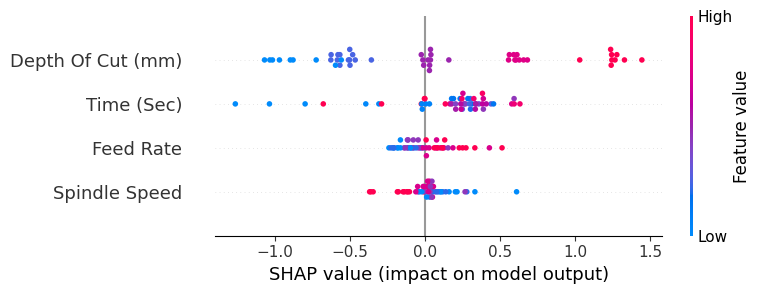


🔹 SHAP Summary for PINN


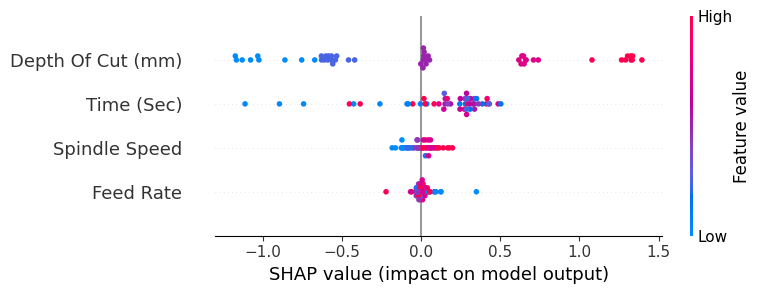


🔹 Mean |SHAP| Feature Importance (ANN vs PINN)


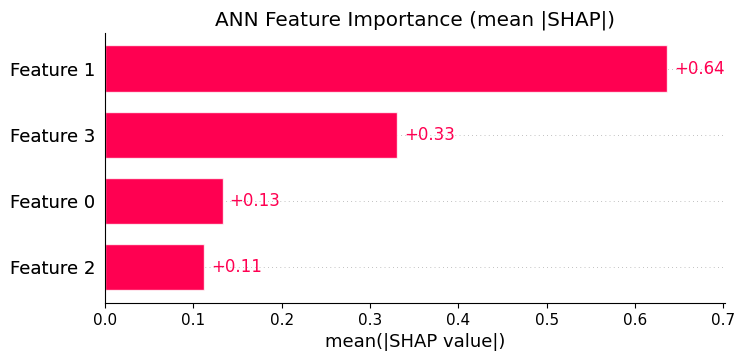

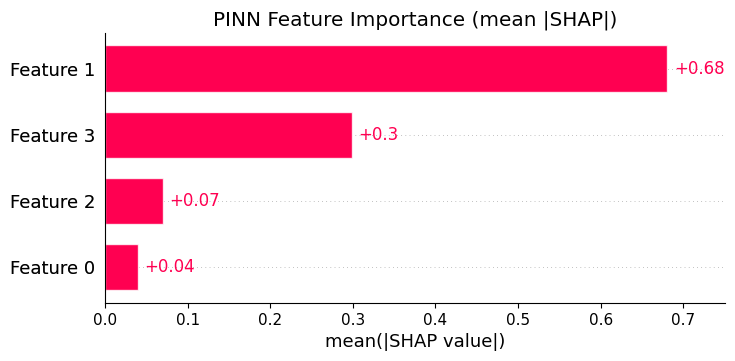

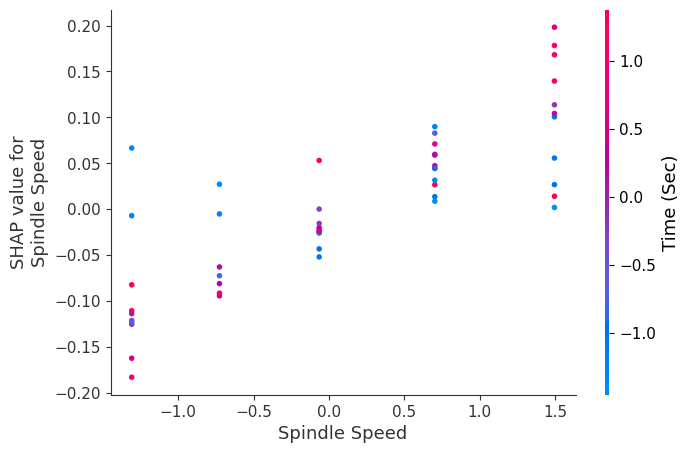

In [ ]:
# ======================
# SHAP Explainability
# ======================
import shap

# pick a background dataset (smaller sample to speed up SHAP)
background = X_train[:200]   # scaled input features
test_samples = X_test[:50]   # just 50 test samples for visualization

# ANN explainer
explainer_ann = shap.Explainer(ann, background)
shap_values_ann = explainer_ann(test_samples)

# PINN explainer
explainer_pinn = shap.Explainer(pinn, background)
shap_values_pinn = explainer_pinn(test_samples)

# Feature names
feature_names = feature_cols

# ----------------
# Summary plots
# ----------------
print("\n🔹 SHAP Summary for ANN")
shap.summary_plot(shap_values_ann, test_samples, feature_names=feature_names, show=True)

print("\n🔹 SHAP Summary for PINN")
shap.summary_plot(shap_values_pinn, test_samples, feature_names=feature_names, show=True)

# ----------------
# Bar plots (average absolute impact per feature)
# ----------------
print("\n🔹 Mean |SHAP| Feature Importance (ANN vs PINN)")
plt.figure(figsize=(10,5))
shap.plots.bar(shap_values_ann, max_display=len(feature_names), show=False)
plt.title("ANN Feature Importance (mean |SHAP|)")
plt.show()

plt.figure(figsize=(10,5))
shap.plots.bar(shap_values_pinn, max_display=len(feature_names), show=False)
plt.title("PINN Feature Importance (mean |SHAP|)")
plt.show()

# ----------------
# Dependence plot (example: Spindle Speed influence)
# ----------------
shap.dependence_plot("Spindle Speed", shap_values_pinn.values, test_samples,
                     feature_names=feature_names, show=True)


In [ ]:
# =========================
# ANN vs 3 PINNs
# =========================

# (Keep your imports, data loading, scalers, physics_power_from_raw from earlier!)

# -------------------------
# Method 1: Soft Constraint PINN
# -------------------------
def train_pinn_soft(model, X_train_scaled, X_train_raw, y_train_scaled,
                    lambda_phys=0.02, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()
    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        batch_data_losses, batch_phys_losses, batch_total_losses = [], [], []

        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_scaled, training=True)
                data_loss = mse(y_true, y_pred)

                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_tf))
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            batch_data_losses.append(data_loss.numpy())
            batch_phys_losses.append(phys_loss.numpy())
            batch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(batch_data_losses))
        history["phys_loss"].append(np.mean(batch_phys_losses))
        history["total_loss"].append(np.mean(batch_total_losses))

    return model, history


# -------------------------
# Method 2: Hybrid PINN (multi-task)
# -------------------------
def build_pinn_hybrid(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="tanh")(inputs)
    x = layers.Dense(64, activation="tanh")(x)
    out_data = layers.Dense(1, name="data_output")(x)
    out_phys = layers.Dense(1, name="phys_output")(x)
    model = keras.Model(inputs=inputs, outputs=[out_data, out_phys])
    return model

def train_pinn_hybrid(model, X_train_scaled, X_train_raw, y_train_scaled, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)
    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        d_losses, p_losses, t_losses = [], [], []
        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_data, y_phys = model(x_scaled, training=True)

                data_loss = mse(y_true, y_data)

                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = mse(P_phys_tf, y_phys)

                total_loss = data_loss + 0.5 * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            d_losses.append(data_loss.numpy())
            p_losses.append(phys_loss.numpy())
            t_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(d_losses))
        history["phys_loss"].append(np.mean(p_losses))
        history["total_loss"].append(np.mean(t_losses))

    return model, history


# -------------------------
# Method 3: Physics-Guided Feature PINN
# -------------------------
def add_physics_feature(X_raw, X_scaled):
    P_phys = physics_power_from_raw(X_raw)
    P_phys_scaled = scaler_y.transform(P_phys)
    return np.hstack([X_scaled, P_phys_scaled])

X_train_pg = add_physics_feature(X_train_raw, X_train)
X_test_pg = add_physics_feature(X_test_raw, X_test)

def build_pinn_pg(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model


# -------------------------
# Train all models
# -------------------------
# ANN
ann = build_ann(X_train.shape[1])
ann.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

# PINN 1 (Soft constraint)
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, hist_soft = train_pinn_soft(pinn_soft, X_train, X_train_raw, y_train, epochs=300)

# PINN 2 (Hybrid)
pinn_hybrid = build_pinn_hybrid(X_train.shape[1])
pinn_hybrid, hist_hybrid = train_pinn_hybrid(pinn_hybrid, X_train, X_train_raw, y_train, epochs=300)

# PINN 3 (Physics-guided feature)
pinn_pg = build_pinn_pg(X_train_pg.shape[1])
pinn_pg.fit(X_train_pg, y_train, epochs=300, batch_size=32, verbose=0)

# -------------------------
# Evaluate all models
# -------------------------
def evaluate_model(model, X_scaled, X_raw, y_true, type="ann"):
    if type == "pg":
        X_in = add_physics_feature(X_raw, X_scaled)
        yhat_scaled = model.predict(X_in)
    elif type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    yhat = scaler_y.inverse_transform(yhat_scaled)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2 = r2_score(y_true, yhat)
    return mse, mae, r2

results = {
    "ANN": evaluate_model(ann, X_test, X_test_raw, y_test_raw, "ann"),
    "PINN_Soft": evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, "soft"),
    "PINN_Hybrid": evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, "hybrid"),
    "PINN_Feature": evaluate_model(pinn_pg, X_test, X_test_raw, y_test_raw, "pg"),
}

print("\nModel Comparison (MSE, MAE, R2):")
for k,v in results.items():
    print(f"{k}: MSE={v[0]:.2f}, MAE={v[1]:.2f}, R2={v[2]:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Model Comparison (MSE, MAE, R2):
ANN: MSE=6253.70, MAE=59.43, R2=0.950
PINN_Soft: MSE=7226.78, MAE=59.88, R2=0.943
PINN_Hybrid: MSE=11065.97, MAE=74.46, R2=0.912
PINN_Feature: MSE=6704.40, MAE=60.39, R2=0.947


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


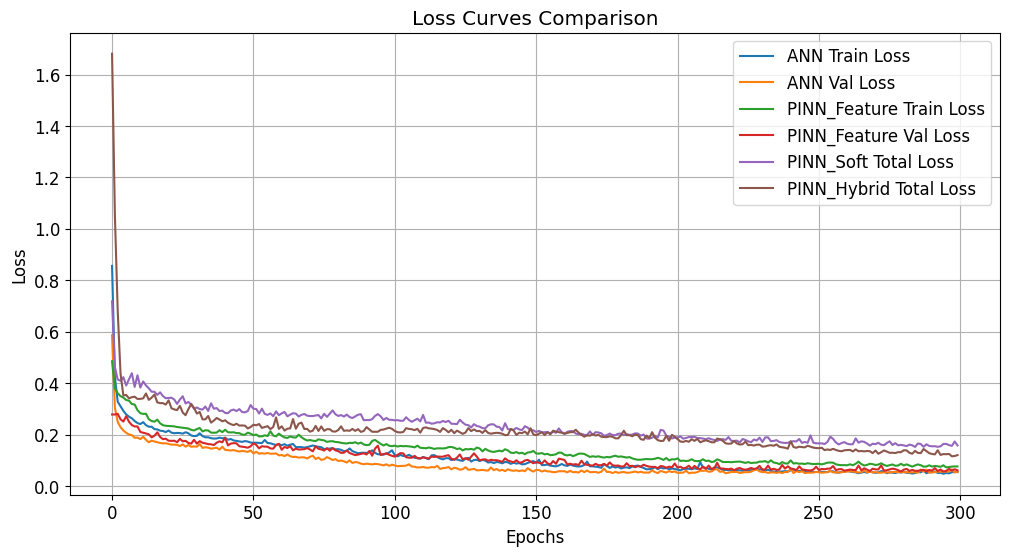

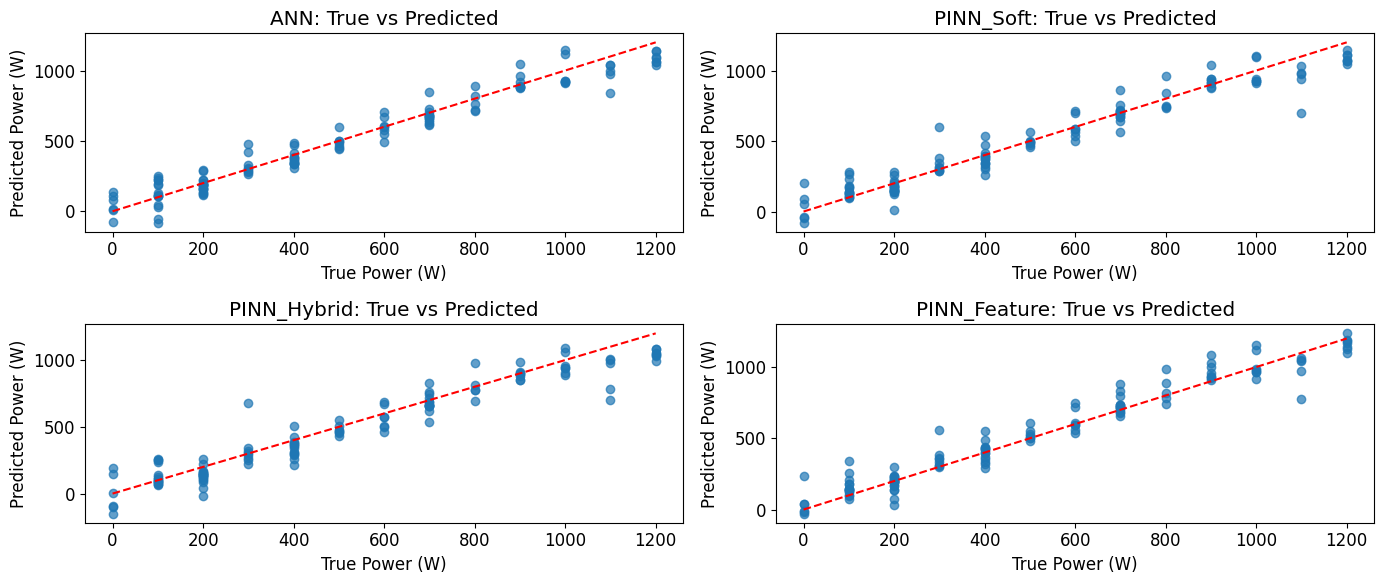

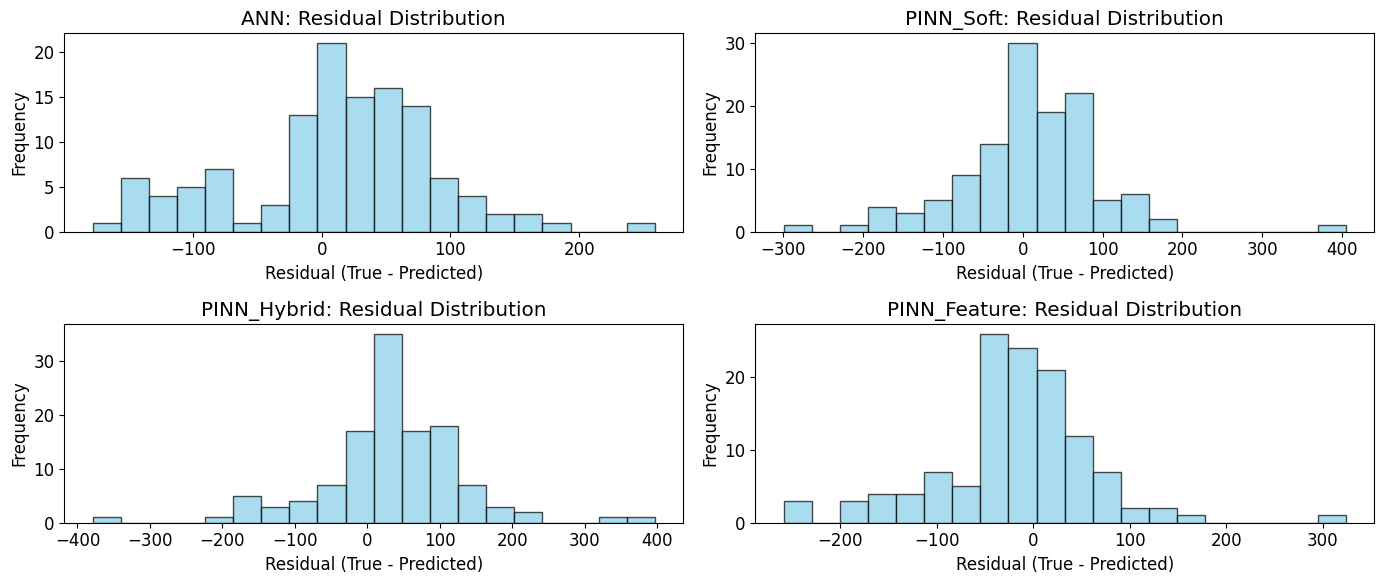

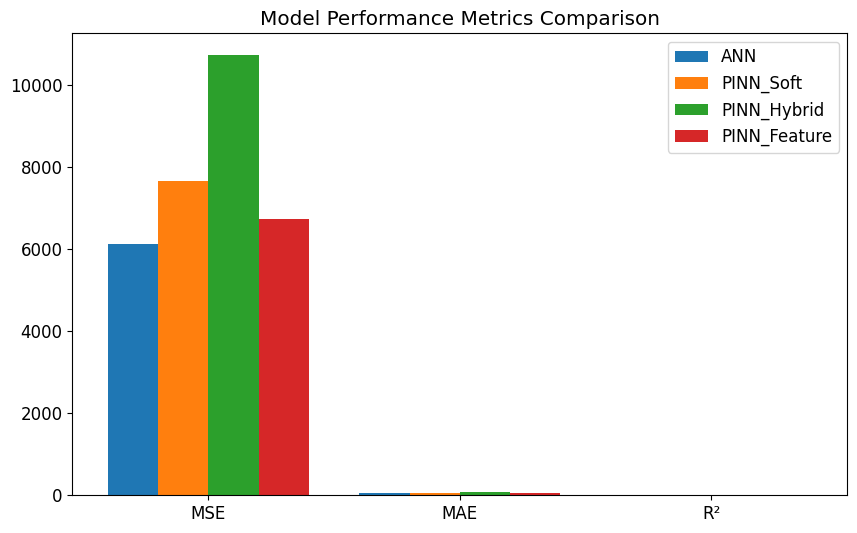


Model Comparison (MSE, MAE, R2):
ANN: MSE=6113.21, MAE=61.09, R2=0.952
PINN_Soft: MSE=7660.72, MAE=63.00, R2=0.939
PINN_Hybrid: MSE=10717.87, MAE=76.75, R2=0.915
PINN_Feature: MSE=6736.85, MAE=56.55, R2=0.947


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# Functions (use from previous code for ANN, PINN Soft, PINN Hybrid, PINN Feature)
# -------------------------

def evaluate_model(model, X_scaled, X_raw, y_true, scaler_y, type="ann"):
    """Evaluate model on test data"""
    if type == "pg":
        X_in = add_physics_feature(X_raw, X_scaled)
        yhat_scaled = model.predict(X_in)
    elif type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    yhat = scaler_y.inverse_transform(yhat_scaled)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2 = r2_score(y_true, yhat)
    return mse, mae, r2, yhat

# -------------------------
# Train all models
# -------------------------

# ANN
ann = build_ann(X_train.shape[1])
hist_ann = ann.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0, validation_data=(X_test, y_test))

# PINN 1: Soft
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, hist_soft = train_pinn_soft(pinn_soft, X_train, X_train_raw, y_train, epochs=300)

# PINN 2: Hybrid
pinn_hybrid = build_pinn_hybrid(X_train.shape[1])
pinn_hybrid, hist_hybrid = train_pinn_hybrid(pinn_hybrid, X_train, X_train_raw, y_train, epochs=300)

# PINN 3: Physics-guided feature
pinn_pg = build_pinn_pg(X_train_pg.shape[1])
hist_pg = pinn_pg.fit(X_train_pg, y_train, epochs=300, batch_size=32, verbose=0, validation_data=(X_test_pg, y_test))

# -------------------------
# Evaluate all models
# -------------------------
results = {}
predictions = {}

results["ANN"], predictions["ANN"] = evaluate_model(ann, X_test, X_test_raw, y_test_raw, scaler_y, "ann")[:3], evaluate_model(ann, X_test, X_test_raw, y_test_raw, scaler_y, "ann")[3]
results["PINN_Soft"], predictions["PINN_Soft"] = evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, scaler_y, "soft")[:3], evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, scaler_y, "soft")[3]
results["PINN_Hybrid"], predictions["PINN_Hybrid"] = evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, scaler_y, "hybrid")[:3], evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, scaler_y, "hybrid")[3]
results["PINN_Feature"], predictions["PINN_Feature"] = evaluate_model(pinn_pg, X_test, X_test_raw, y_test_raw, scaler_y, "pg")[:3], evaluate_model(pinn_pg, X_test, X_test_raw, y_test_raw, scaler_y, "pg")[3]

# -------------------------
# 📊 Plots
# -------------------------

# 1. Loss Curves
plt.figure(figsize=(12,6))
plt.plot(hist_ann.history['loss'], label="ANN Train Loss")
plt.plot(hist_ann.history['val_loss'], label="ANN Val Loss")
plt.plot(hist_pg.history['loss'], label="PINN_Feature Train Loss")
plt.plot(hist_pg.history['val_loss'], label="PINN_Feature Val Loss")
plt.plot(hist_soft['total_loss'], label="PINN_Soft Total Loss")
plt.plot(hist_hybrid['total_loss'], label="PINN_Hybrid Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()

# 2. True vs Predicted
plt.figure(figsize=(14,6))
for i, model in enumerate(results.keys()):
    plt.subplot(2,2,i+1)
    plt.scatter(y_test_raw, predictions[model], alpha=0.7)
    plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--')
    plt.title(f"{model}: True vs Predicted")
    plt.xlabel("True Power (W)")
    plt.ylabel("Predicted Power (W)")
plt.tight_layout()
plt.show()

# 3. Residuals
plt.figure(figsize=(14,6))
for i, model in enumerate(results.keys()):
    plt.subplot(2,2,i+1)
    residuals = y_test_raw.flatten() - predictions[model].flatten()
    plt.hist(residuals, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
    plt.title(f"{model}: Residual Distribution")
    plt.xlabel("Residual (True - Predicted)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4. Metrics Bar Chart
metrics = ["MSE", "MAE", "R²"]
x = np.arange(len(metrics))
bar_width = 0.2

plt.figure(figsize=(10,6))
for i, (model, vals) in enumerate(results.items()):
    plt.bar(x + i*bar_width, vals, width=bar_width, label=model)

plt.xticks(x + bar_width*1.5, metrics)
plt.title("Model Performance Metrics Comparison")
plt.legend()
plt.show()

# -------------------------
# Print Results
# -------------------------
print("\nModel Comparison (MSE, MAE, R2):")
for model, vals in results.items():
    print(f"{model}: MSE={vals[0]:.2f}, MAE={vals[1]:.2f}, R2={vals[2]:.3f}")


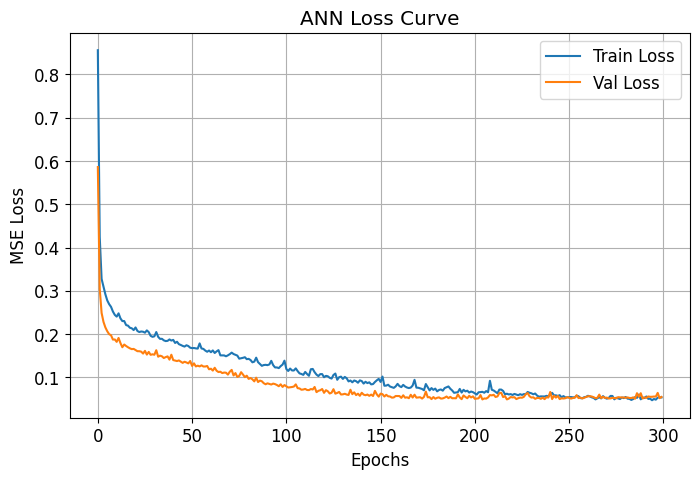

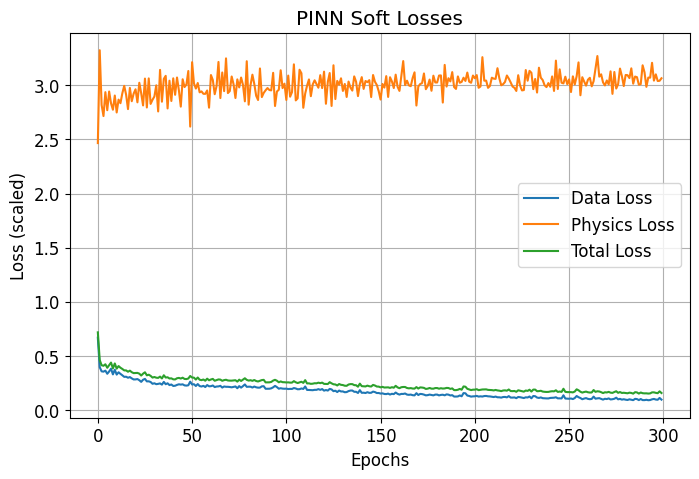

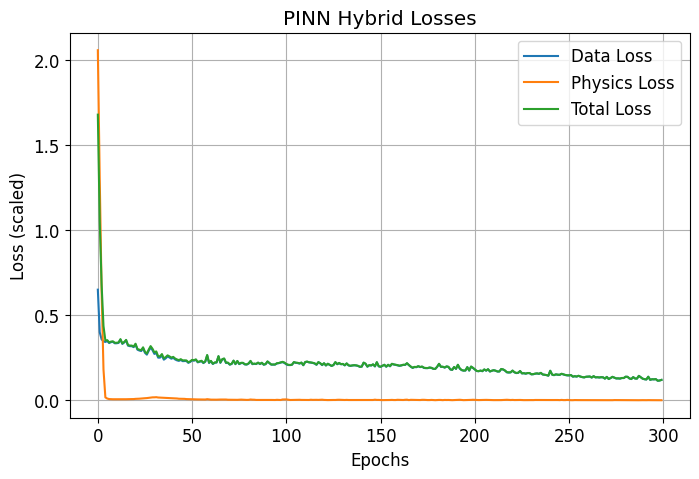

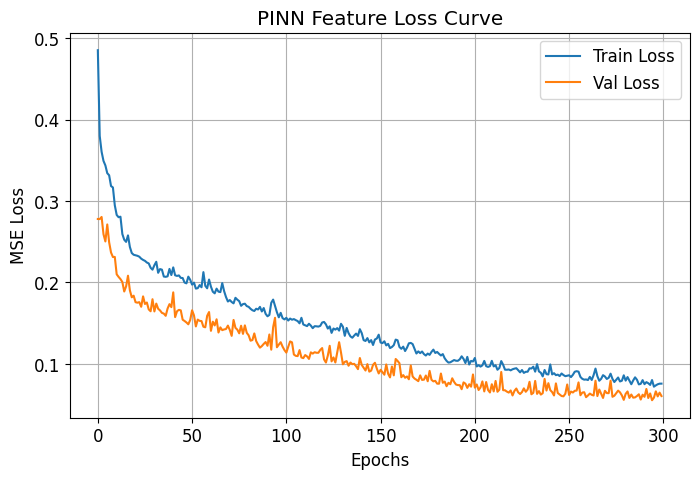

In [ ]:
# =========================
# 📊 Separate Loss Curves
# =========================

# 1. ANN Loss Curve
plt.figure(figsize=(8,5))
plt.plot(hist_ann.history['loss'], label="Train Loss")
plt.plot(hist_ann.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
plt.title("ANN Loss Curve")
plt.legend(); plt.grid(True)
plt.show()

# 2. PINN Soft Losses
plt.figure(figsize=(8,5))
plt.plot(hist_soft['data_loss'], label="Data Loss")
plt.plot(hist_soft['phys_loss'], label="Physics Loss")
plt.plot(hist_soft['total_loss'], label="Total Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss (scaled)")
plt.title("PINN Soft Losses")
plt.legend(); plt.grid(True)
plt.show()

# 3. PINN Hybrid Losses
plt.figure(figsize=(8,5))
plt.plot(hist_hybrid['data_loss'], label="Data Loss")
plt.plot(hist_hybrid['phys_loss'], label="Physics Loss")
plt.plot(hist_hybrid['total_loss'], label="Total Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss (scaled)")
plt.title("PINN Hybrid Losses")
plt.legend(); plt.grid(True)
plt.show()

# 4. PINN Feature Loss Curve
plt.figure(figsize=(8,5))
plt.plot(hist_pg.history['loss'], label="Train Loss")
plt.plot(hist_pg.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
plt.title("PINN Feature Loss Curve")
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
# =====================================================
# Feature-PINN Physics Consistency Evaluation
# =====================================================

# Compute physics-based power for test set
def compute_physics_power(X):
    feed = X[:, 0]
    depth = X[:, 1]
    spindle = X[:, 2]

    # physics parameters
    K_tc = 2517.58
    K_te = 18.9
    r = 5.0

    # Chip thickness (simplified)
    h_phi = feed * np.sin(np.pi / 4)

    # Cutting force model
    F_t = (K_tc * h_phi * depth) + (K_te * depth)
    T_c = F_t * r  # torque
    omega = (2 * np.pi * spindle) / 60.0  # rad/s
    P_phys = T_c * omega
    return P_phys

# Get predictions
y_pred_feature_scaled = pinn_feature.predict(X_test_scaled)
y_pred_feature = scaler_y.inverse_transform(y_pred_feature_scaled)

# Physics-based predictions
P_phys_test = compute_physics_power(X_test)

# =====================================================
# Comparative Plots for Feature-PINN Physics Consistency
# =====================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

# 1. Scatter: Model vs Physics
plt.subplot(1, 3, 1)
plt.scatter(P_phys_test, y_pred_feature, alpha=0.6, color='blue')
plt.plot([P_phys_test.min(), P_phys_test.max()],
         [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel("Physics Power (W)")
plt.ylabel("Feature-PINN Prediction (W)")
plt.title("Feature-PINN vs Physics Power")

# 2. Residuals line plot
residuals = y_pred_feature.flatten() - P_phys_test
plt.subplot(1, 3, 2)
plt.plot(residuals, label="Residuals")
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (Pred - Phys)")
plt.title("Physics Consistency Residuals")

# 3. Residuals Histogram
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=20, color='green', alpha=0.7)
plt.xlabel("Residual (Pred - Phys)")
plt.ylabel("Frequency")
plt.title("Distribution of Physics Consistency Error")

plt.tight_layout()
plt.show()


InvalidArgumentError: Graph execution error:

Detected at node sequential_18_1/dense_58_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-1604046745.py", line 27, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 566, in predict

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 260, in one_step_on_data_distributed

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 250, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in predict_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/sequential.py", line 220, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py", line 155, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/activations/activations.py", line 47, in relu

  File "/usr/local/lib/python3.12/dist-packages/keras/src/activations/activations.py", line 101, in static_call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [32,4], In[1]: [5,64]
	 [[{{node sequential_18_1/dense_58_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_16312008]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔹 Model Comparison:
ANN: {'MSE': 5599.142578125, 'MAE': 55.246925354003906, 'R2': 0.9555866718292236}
Soft-PINN: {'MSE': 12176964608.0, 'MAE': 110348.703125, 'R2': -96588.734375}
Hybrid-PINN: {'MSE': 12210680832.0, 'MAE': 110501.375, 'R2': -96856.171875}
Feature-PINN: {'MSE': 174081.796875, 'MAE': 358.7463684082031, 'R2': -0.38084614276885986}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


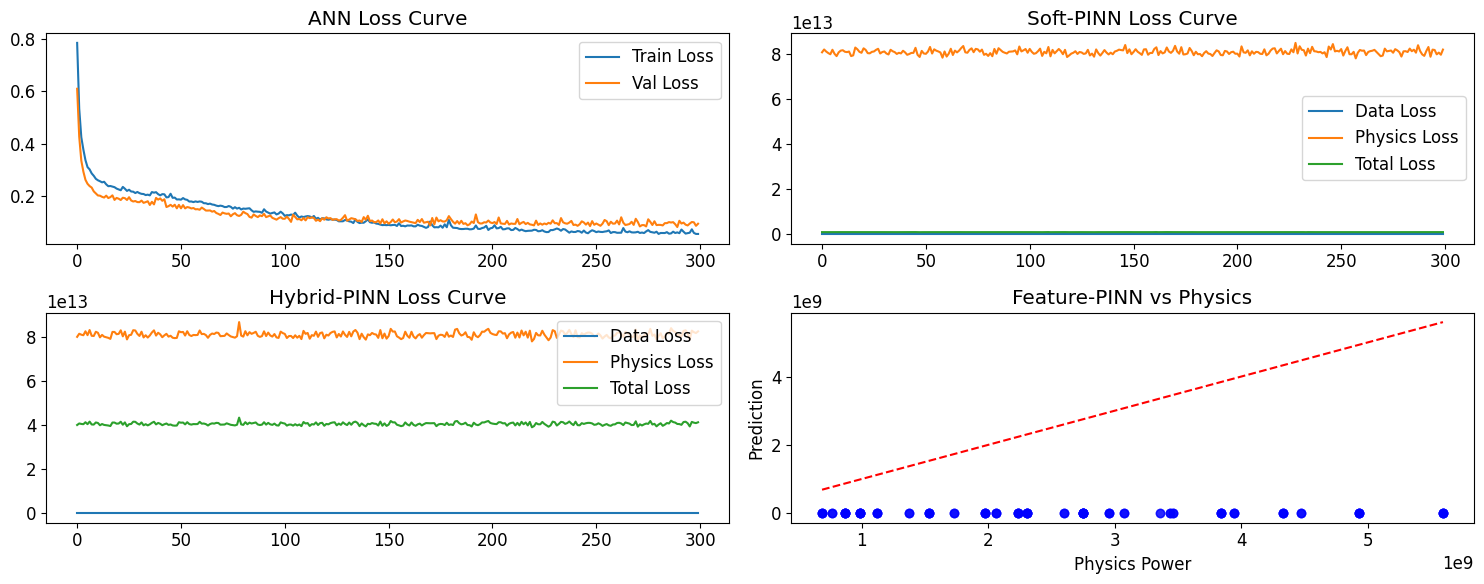

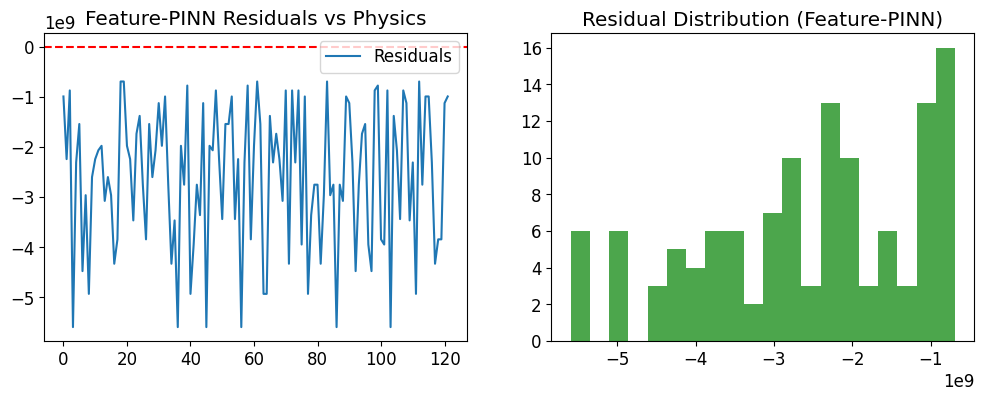

In [ ]:
# =====================================================
# Imports
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =====================================================
# Load Data
# =====================================================
data = pd.read_csv("/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv",
                   encoding="ISO-8859-1")

X = data[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y = data["P (w)"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)

# =====================================================
# Physics Model (cutting mechanics)
# =====================================================
def compute_physics_power(X):
    feed = X[:, 0]
    depth = X[:, 1]
    spindle = X[:, 2]

    K_tc = 2517.58
    K_te = 18.9
    r = 5.0

    h_phi = feed * np.sin(np.pi / 4)
    F_t = (K_tc * h_phi * depth) + (K_te * depth)
    T_c = F_t * r
    omega = (2 * np.pi * spindle) / 60.0
    P_phys = T_c * omega
    return P_phys.reshape(-1, 1)

# =====================================================
# Build Models
# =====================================================
def build_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

def build_pinn(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation="tanh", input_shape=(input_dim,)),
        keras.layers.Dense(64, activation="tanh"),
        keras.layers.Dense(1)
    ])
    return model

# =====================================================
# Custom Training for PINNs
# =====================================================
def train_pinn(model, X_train, y_train, lambda_phys=0.01, epochs=300, batch_size=32, mode="soft"):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(batch_size)
    optimizer = keras.optimizers.Adam(1e-3)
    mse_loss = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        batch_data_loss, batch_phys_loss, batch_total_loss = [], [], []

        for xb, yb in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(xb, training=True)
                data_loss = mse_loss(yb, y_pred)

                # Physics prediction
                xb_np = xb.numpy()
                P_phys = compute_physics_power(scaler_X.inverse_transform(xb_np))
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_scaled = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_scaled))

                if mode == "soft":
                    total_loss = data_loss + lambda_phys * phys_loss
                elif mode == "hybrid":
                    total_loss = 0.5 * data_loss + 0.5 * phys_loss
                else:
                    total_loss = data_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            batch_data_loss.append(data_loss.numpy())
            batch_phys_loss.append(phys_loss.numpy())
            batch_total_loss.append(total_loss.numpy())

        history["data_loss"].append(np.mean(batch_data_loss))
        history["phys_loss"].append(np.mean(batch_phys_loss))
        history["total_loss"].append(np.mean(batch_total_loss))

    return model, history

# =====================================================
# Train ANN
# =====================================================
ann = build_ann(X_train.shape[1])
history_ann = ann.fit(X_train_scaled, y_train_scaled, validation_split=0.2,
                      epochs=300, batch_size=32, verbose=0)

# =====================================================
# Train Soft-PINN
# =====================================================
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, history_soft = train_pinn(pinn_soft, X_train_tensor, y_train_tensor,
                                     lambda_phys=0.01, epochs=300, mode="soft")

# =====================================================
# Train Hybrid-PINN
# =====================================================
pinn_hybrid = build_pinn(X_train.shape[1])
pinn_hybrid, history_hybrid = train_pinn(pinn_hybrid, X_train_tensor, y_train_tensor,
                                         lambda_phys=0.01, epochs=300, mode="hybrid")

# =====================================================
# Train Feature-PINN (ANN + physics feature)
# =====================================================
P_phys_train = compute_physics_power(X_train)
P_phys_test = compute_physics_power(X_test)
X_train_feature = np.hstack([X_train_scaled, scaler_y.transform(P_phys_train)])
X_test_feature = np.hstack([X_test_scaled, scaler_y.transform(P_phys_test)])

pinn_feature = build_ann(X_train_feature.shape[1])
history_feature = pinn_feature.fit(X_train_feature, y_train_scaled, validation_split=0.2,
                                   epochs=300, batch_size=32, verbose=0)

# =====================================================
# Evaluation
# =====================================================
def evaluate_model(model, X_test, y_test, feature=False):
    if feature:
        y_pred_scaled = model.predict(X_test_feature)
    else:
        y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    return {
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

results = {
    "ANN": evaluate_model(ann, X_test, y_test, feature=False),
    "Soft-PINN": evaluate_model(pinn_soft, X_test, y_test, feature=False),
    "Hybrid-PINN": evaluate_model(pinn_hybrid, X_test, y_test, feature=False),
    "Feature-PINN": evaluate_model(pinn_feature, X_test, y_test, feature=True),
}

print("\n🔹 Model Comparison:")
for k, v in results.items():
    print(f"{k}: {v}")

# =====================================================
# Plots: ANN vs PINNs
# =====================================================
plt.figure(figsize=(15, 6))

# ANN Loss
plt.subplot(2, 2, 1)
plt.plot(history_ann.history["loss"], label="Train Loss")
plt.plot(history_ann.history["val_loss"], label="Val Loss")
plt.title("ANN Loss Curve")
plt.legend()

# Soft-PINN Loss
plt.subplot(2, 2, 2)
plt.plot(history_soft["data_loss"], label="Data Loss")
plt.plot(history_soft["phys_loss"], label="Physics Loss")
plt.plot(history_soft["total_loss"], label="Total Loss")
plt.title("Soft-PINN Loss Curve")
plt.legend()

# Hybrid-PINN Loss
plt.subplot(2, 2, 3)
plt.plot(history_hybrid["data_loss"], label="Data Loss")
plt.plot(history_hybrid["phys_loss"], label="Physics Loss")
plt.plot(history_hybrid["total_loss"], label="Total Loss")
plt.title("Hybrid-PINN Loss Curve")
plt.legend()

# Feature-PINN Consistency
y_pred_feature_scaled = pinn_feature.predict(X_test_feature)
y_pred_feature = scaler_y.inverse_transform(y_pred_feature_scaled)
residuals = y_pred_feature.flatten() - P_phys_test.flatten()

plt.subplot(2, 2, 4)
plt.scatter(P_phys_test, y_pred_feature, alpha=0.6, color='blue')
plt.plot([P_phys_test.min(), P_phys_test.max()],
         [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.title("Feature-PINN vs Physics")
plt.xlabel("Physics Power")
plt.ylabel("Prediction")

plt.tight_layout()
plt.show()

# Residual Analysis for Feature-PINN
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(residuals, label="Residuals")
plt.axhline(0, color='r', linestyle="--")
plt.title("Feature-PINN Residuals vs Physics")
plt.legend()

plt.subplot(1,2,2)
plt.hist(residuals, bins=20, color="green", alpha=0.7)
plt.title("Residual Distribution (Feature-PINN)")
plt.show()

# =====================================================
# Save Models (Correct Filenames)
# =====================================================
ann.save("ann_model.keras")
pinn_soft.save_weights("soft_pinn.weights.h5")
pinn_hybrid.save_weights("hybrid_pinn.weights.h5")
pinn_feature.save("feature_pinn_model.keras")
